<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2025/Practica_5_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 8: Inferencia estadística

En este clase vamos a utilizar librerías para resolver numéricamente (utilizando cadenas de Markov e inferencia variacional) problemas de inferencia estadística. Esto nos permitirá resolver problemas más complejos, y dar mayor libertad a la hora de modelar la generación de datos y de elegir distribuciones a priori de los parámetros.

En particular usaremos dos librerías:
- [Bambi](https://bambinos.github.io/bambi/) (BAyesian Model-Building Interface): para la construcción y calibración de modelos
- [ArviZ](https://python.arviz.org/en/stable/): para la visualización de los resultados de la inferencia y la evaluación de los modelos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files

# Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

# ArviZ
import arviz as az

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.9 MB/s eta 0:00:00


## Ejemplo 1: Lluvia centenaria en CABA

En este primer ejemplo, vamos a seguir el ajuste de un modelo para predecir la máxima lluvia diaria anual en la Ciudad de Buenos Aires.

La pregunta que queremos contestar es:
 ¿Cuál es la lluvia que ocurre una vez (se supera) cada 100 años? O dicho más correctamente, la lluvia cuyo período de recurrencia es 100 años.

 Para ello, tenemos los datos de lluvia del servicio meteorológico nacional vistos en clases anteriores, y cuya limpieza ya tratamos con detenimiento.

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving PRECIPITACIONES.csv to PRECIPITACIONES.csv


In [ ]:
#Se crea un DataFrame
df_lluvia = pd.read_csv(io.BytesIO(uploaded['PRECIPITACIONES.csv']),encoding='ISO-8859-1', sep=';', skiprows=5, header=0)
df_lluvia

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,S/P,S/P,S/P,S/P,S/P,0.4,3.9,25.2,S/P,S/P,S/P,13.3
1,2,S/P,0.1,S/P,S/P,S/P,3.6,2.5,0.2,S/P,S/P,S/P,0.2
2,3,S/P,S/P,S/P,S/P,S/P,1.7,S/P,S/P,S/P,S/P,12.7,S/P
3,4,S/P,S/P,S/P,S/P,S/P,1.5,S/P,S/P,11.2,S/P,S/P,4
4,5,S/P,S/P,S/P,S/P,0.3,S/P,S/P,S/P,S/P,S/P,14.8,S/P
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4511,28,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN
4512,29,S/P,0.1,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN
4513,30,S/P,NaN,<0.1,3,S/P,S/P,S/P,84.1,NaN,NaN,NaN,NaN
4514,31,S/P,NaN,<0.1,NaN,S/P,NaN,S/P,34,NaN,NaN,NaN,NaN


### Limpieza y Ordenamiento

Aquí van a encontrar en forma resumida la limpieza necesaria para generar el dataset de lluvias máximas anuales.

In [ ]:
row_keep = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31']

# Guardar solo los datos asociados a Días reales
df_lluvia = df_lluvia.copy()[df_lluvia['Día'].isin(row_keep)].reset_index(drop=True)
df_lluvia

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,1,S/P,S/P,S/P,S/P,S/P,0.4,3.9,25.2,S/P,S/P,S/P,13.3
1,2,S/P,0.1,S/P,S/P,S/P,3.6,2.5,0.2,S/P,S/P,S/P,0.2
2,3,S/P,S/P,S/P,S/P,S/P,1.7,S/P,S/P,S/P,S/P,12.7,S/P
3,4,S/P,S/P,S/P,S/P,S/P,1.5,S/P,S/P,11.2,S/P,S/P,4
4,5,S/P,S/P,S/P,S/P,0.3,S/P,S/P,S/P,S/P,S/P,14.8,S/P
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684,27,S/P,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,NaN,NaN,NaN,NaN
3685,28,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN
3686,29,S/P,0.1,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN
3687,30,S/P,NaN,<0.1,3,S/P,S/P,S/P,84.1,NaN,NaN,NaN,NaN


Cada 31 filas cambia el año, así que puedo generar un loop para armar el dataset. Primero, defino el año asociada a cada fila.

In [ ]:
# año inicial
ano_ini = 1906

# creo la columna año
df_lluvia['Año'] = 1906

# itero en los las filas de mi dataset para sumar cada "31 dias"
for i in range(df_lluvia.shape[0]):
  df_lluvia.loc[i,'Año'] = int(ano_ini + int(i/31))

df_lluvia

,Día,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Año
0,1,S/P,S/P,S/P,S/P,S/P,0.4,3.9,25.2,S/P,S/P,S/P,13.3,1906
1,2,S/P,0.1,S/P,S/P,S/P,3.6,2.5,0.2,S/P,S/P,S/P,0.2,1906
2,3,S/P,S/P,S/P,S/P,S/P,1.7,S/P,S/P,S/P,S/P,12.7,S/P,1906
3,4,S/P,S/P,S/P,S/P,S/P,1.5,S/P,S/P,11.2,S/P,S/P,4,1906
4,5,S/P,S/P,S/P,S/P,0.3,S/P,S/P,S/P,S/P,S/P,14.8,S/P,1906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684,27,S/P,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,NaN,NaN,NaN,NaN,2024
3685,28,S/P,S/P,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN,2024
3686,29,S/P,0.1,S/P,<0.1,S/P,S/P,S/P,S/P,NaN,NaN,NaN,NaN,2024
3687,30,S/P,NaN,<0.1,3,S/P,S/P,S/P,84.1,NaN,NaN,NaN,NaN,2024


Luego, ¡hago un reordenamiento de los datos! Para esto podemos usar la función `melt` de Pandas, que es una forma de mergear valores.

In [ ]:
# Armo una matriz de datos
df_lluvia = df_lluvia.copy().melt(id_vars=['Día','Año'],var_name='Mes',
                                   value_name='Precipitación')
df_lluvia

,Día,Año,Mes,Precipitación
0,1,1906,Ene,S/P
1,2,1906,Ene,S/P
2,3,1906,Ene,S/P
3,4,1906,Ene,S/P
4,5,1906,Ene,S/P
...,...,...,...,...
44263,27,2024,Dic,NaN
44264,28,2024,Dic,NaN
44265,29,2024,Dic,NaN
44266,30,2024,Dic,NaN


Ahora podemos trabajar el dataframe un poco más. primero, podemos eliminar los **NaN** (días que no existen, como el 31 de febrero)

In [ ]:
df_lluvia = df_lluvia.copy().dropna().reset_index(drop=True)
df_lluvia

,Día,Año,Mes,Precipitación
0,1,1906,Ene,S/P
1,2,1906,Ene,S/P
2,3,1906,Ene,S/P
3,4,1906,Ene,S/P
4,5,1906,Ene,S/P
...,...,...,...,...
43338,27,2023,Dic,6.3
43339,28,2023,Dic,S/P
43340,29,2023,Dic,S/P
43341,30,2023,Dic,S/P


Ahora vamos a generar la fecha y ordenar cronológicamente

In [ ]:
#diccionario que relaciona mes con numero
dic_mes = {'Ene':1,'Feb':2,'Mar':3,'Abr':4,'May':5,'Jun':6,'Jul':7,
           'Ago':8,'Sep':9,'Oct':10,'Nov':11,'Dic':12}

# Cambiar columna mes a números
df_lluvia['Mes'] = df_lluvia['Mes'].copy().replace(dic_mes)

# Crear
df_lluvia['Fecha'] = pd.to_datetime(df_lluvia['Año'].astype(str) + '-' +
                                    df_lluvia['Mes'].astype(str) + '-' + df_lluvia['Día'].astype(str),
                                    format='ISO8601')
df_lluvia

<ipython-input-8-a4b220045c39>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_lluvia['Mes'] = df_lluvia['Mes'].copy().replace(dic_mes)


,Día,Año,Mes,Precipitación,Fecha
0,1,1906,1,S/P,1906-01-01
1,2,1906,1,S/P,1906-01-02
2,3,1906,1,S/P,1906-01-03
3,4,1906,1,S/P,1906-01-04
4,5,1906,1,S/P,1906-01-05
...,...,...,...,...,...
43338,27,2023,12,6.3,2023-12-27
43339,28,2023,12,S/P,2023-12-28
43340,29,2023,12,S/P,2023-12-29
43341,30,2023,12,S/P,2023-12-30


In [ ]:
# ordernar cronologicamente los datos
df_lluvia = df_lluvia.copy().sort_values(by='Fecha').reset_index(drop=True)

df_lluvia

,Día,Año,Mes,Precipitación,Fecha
0,1,1906,1,S/P,1906-01-01
1,2,1906,1,S/P,1906-01-02
2,3,1906,1,S/P,1906-01-03
3,4,1906,1,S/P,1906-01-04
4,5,1906,1,S/P,1906-01-05
...,...,...,...,...,...
43338,27,2024,8,S/P,2024-08-27
43339,28,2024,8,S/P,2024-08-28
43340,29,2024,8,S/P,2024-08-29
43341,30,2024,8,84.1,2024-08-30


Me aparecen algunas cosas no deseadas:

- S/P: Sin precipitación (debiera ser 0)
- <0.1: llovió, no significativo (podríamos tomarlo como 0)
- S/D: Sin Dato (habría que explicitamente vaciarlo, como `np.nan`)

In [ ]:
# reemplazar S/P y <0.1 por 0
df_lluvia['Precipitación'] = df_lluvia['Precipitación'].copy().replace(['S/P',
                                                                        '<0.1'],0)
# reemplazar S/D por nan
df_lluvia['Precipitación'] = df_lluvia['Precipitación'].copy().replace('S/D',np.nan)

df_lluvia

,Día,Año,Mes,Precipitación,Fecha
0,1,1906,1,0,1906-01-01
1,2,1906,1,0,1906-01-02
2,3,1906,1,0,1906-01-03
3,4,1906,1,0,1906-01-04
4,5,1906,1,0,1906-01-05
...,...,...,...,...,...
43338,27,2024,8,0,2024-08-27
43339,28,2024,8,0,2024-08-28
43340,29,2024,8,0,2024-08-29
43341,30,2024,8,84.1,2024-08-30


Además, habría que setear el tipo de dato correcto a cada columna.

¿Por qué llamo a los datos de día, mes, año como categorías? Porque no voy a trabajar a los datos como una serie de tiempo.

In [ ]:
# Modificar los dtypes a los correctos
df_lluvia['Precipitación'] = df_lluvia['Precipitación'].copy().astype('float')
df_lluvia['Año'] = df_lluvia['Año'].copy().astype('category')
df_lluvia['Mes'] = df_lluvia['Mes'].copy().astype('category')
df_lluvia['Día'] = df_lluvia['Día'].copy().astype('category')

df_lluvia.dtypes

,0
Día,category
Año,category
Mes,category
Precipitación,float64
Fecha,datetime64[ns]


Habiendo hecho todo esto, reordenemos las columnas simplemente para claridad (mía), y veamos finalmente qué tenemos.

In [ ]:
# Reordenar columnas
df_lluvia = df_lluvia.copy()[['Fecha','Precipitación','Año','Mes','Día']]
df_lluvia

,Fecha,Precipitación,Año,Mes,Día
0,1906-01-01,0.0,1906,1,1
1,1906-01-02,0.0,1906,1,2
2,1906-01-03,0.0,1906,1,3
3,1906-01-04,0.0,1906,1,4
4,1906-01-05,0.0,1906,1,5
...,...,...,...,...,...
43338,2024-08-27,0.0,2024,8,27
43339,2024-08-28,0.0,2024,8,28
43340,2024-08-29,0.0,2024,8,29
43341,2024-08-30,84.1,2024,8,30


In [ ]:
# Dataframe de máxima lluvia diaria por año
df_max = df_lluvia.groupby(['Año'],observed=True)[['Precipitación']].agg('max').reset_index()
df_max

,Año,Precipitación
0,1906,80.6
1,1907,76.5
2,1908,73.4
3,1909,52.7
4,1910,51.7
...,...,...
114,2020,79.3
115,2021,72.0
116,2022,101.0
117,2023,69.1


### Resumen

Aquí los datos con los que vamos a trabajar.

In [ ]:
# Dataframe de máxima lluvia diaria por año
df_max

,Año,Precipitación
0,1906,80.6
1,1907,76.5
2,1908,73.4
3,1909,52.7
4,1910,51.7
...,...,...
114,2020,79.3
115,2021,72.0
116,2022,101.0
117,2023,69.1


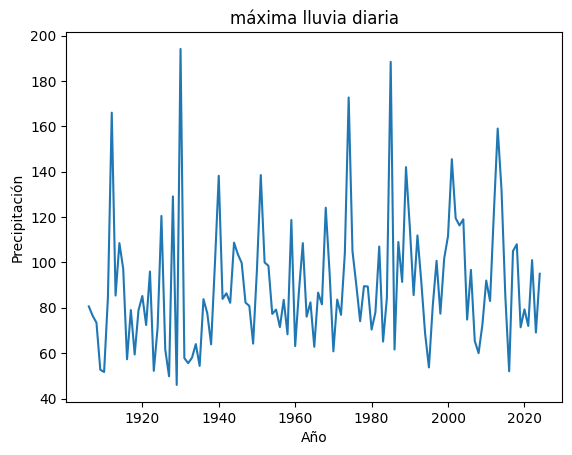

In [ ]:
# Grafico de lluvias
sns.lineplot(df_max,x='Año',y='Precipitación').set(title='máxima lluvia diaria')
plt.show()

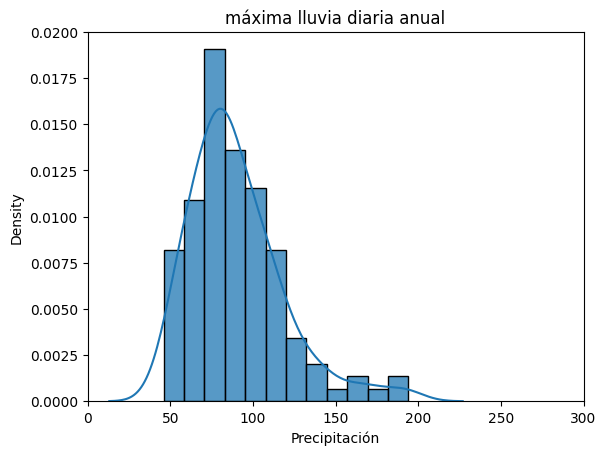

In [ ]:
# histograma
sns.histplot(df_max,x='Precipitación',stat='density').set(title='máxima lluvia diaria anual')
sns.kdeplot(df_max,x='Precipitación')
plt.xlim([0,300])
plt.show()

Viendo los datos, ¿qué distribuciones podríamos proponer para la máxima lluvia diaria anual? ¿Quién los pudo haber generado?

### Construcción del modelo en Bambi

Vamos a contestar las preguntas resolviendo la inferencia por Cadenas de Markov, ya que nos va a dar más flexibilidad para plantear problemas más complejos y más libertad para elegir distribuciones a priori.

#### Ejemplo: El modelo default (una Normal)

La construcción de un modelo de Bambi se hace con la función `Model` (LINK [link text](https://bambinos.github.io/bambi/api/Model.html#bambi.Model)). Hay 3 cosas a definir:
- La Fórmula: Es la ecuación que describe al parámetro "valor medio" (o una transformación de este) de la distribución elegida
- La Familia: Qué función de distribución define la verosimilitud
- El Link: Qué transformación aplica a la fórmula (¿Es para el el valor medio? ¿El logaritmo del valor medio? ¿su inversa?)
- Las distribuciones a priori: `Bambi` tiene opciones poco informativas si todo está por default. La recomendación es adoptarlas ustedes.

La familia por default en `Bambi` es el modelo Normal. Si no aclaramos nada, usará ese. Cada familia tiene, a su vez, un Link por default. En el caso de la Normal es `identity`. Es decir, que estoy ajustando al valor medio:

Modelo:

$$y \sim Normal(\mu , \sigma)$$

Fórmula para el valor medio (a las constantes, `Bambi` las llama `Intercept`:

$$\mu = Intercept \cdot 1$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(m,s)$$

**NOTA**: La fórmula que se escribe es para el valor medio, pero nada se dijo de `sigma`. Eso es porque `Bambi` lo trata como un término de error a todo parámetro adicional del modelo. En este caso, considera por default:

$$\sigma = Sigma \cdot 1$$

$$p(Sigma)\sim Ht_{v}(m,s)$$

La información anterior respecto a las familias cargadas en `Bambi`y sus `links`por default pueden verla [AQUÍ](https://bambinos.github.io/bambi/notebooks/getting_started.html#families)

A continuación, les dejamos un ejemplo de la carga de datos. Vean que los datos provienen de un dataframe `df_max`, y la formula describe a la columna `Precipitación` del dataframe, que es mi variable `y`.

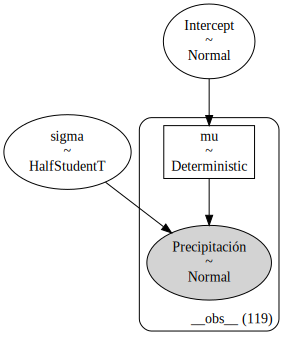

In [ ]:
# Construccion del Modelo Normal
model_Norm = bmb.Model('Precipitación~1',data=df_max)
model_Norm.build()

# Visualizacion
model_Norm.graph()

Con el método `plot_priors` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors)) podemos ver la distribución a priori adoptada. Si queremos ver el intervalo de confianza, con `hdi_prob` podemos setearlo. Podrán ver que la priori de `Bambi` suele ser muy poco informativa.

*Nota*: Recuerden que `Intercept`es el valor medio en este caso.

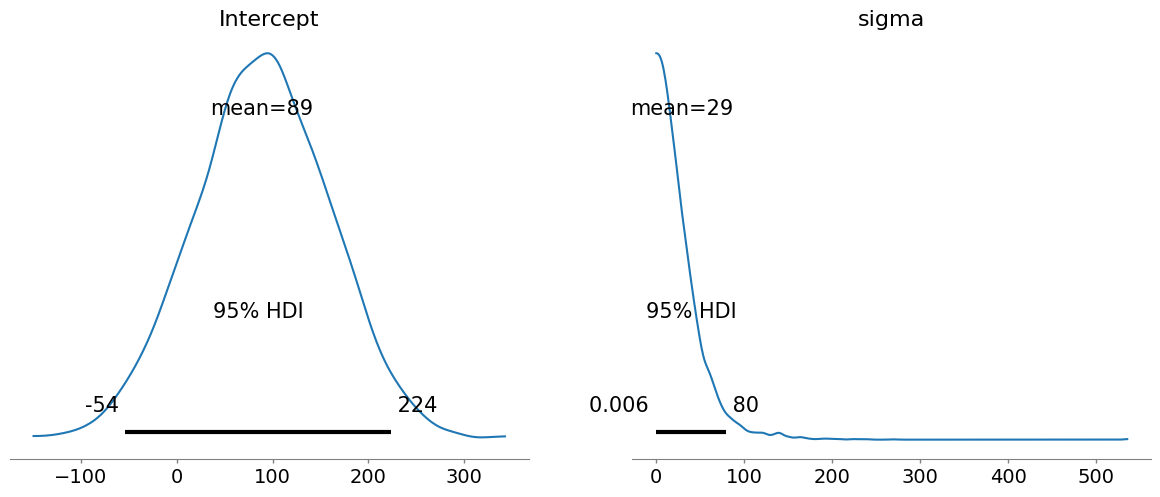

In [ ]:
# Graficar distribuciones a priori
model_Norm.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Detallando las distribuciones a priori y el parámetro a ajustar

Ahora vamos a hacer lo mismo pero definiendo nosotros el link y adoptando nuestra propia distribución a priori para el `Intercept` ($\mu$). Sabemos que $\mu$ es positivo, así que podría tomarle el logaritmo para que sea un número en todos los reales. Luego, tengo que proponer valores "razonables" para la lluvia máxima diaria. Es mi intuición. Si tengo poco conocimiento, elegiré un rango muy amplio.

Digamos, por ejemplo, que la lluvia máxima promedio espero que esté entre 100 y 200.

Entonces:

Mediana: $\mu = 150$

Desvío: $\sigma = 25$

Por lo tanto, el coeficiente de variación es $s = \sigma/\mu = 1/6$.

Tomando el logaritmo, me quedaría:

El modelo que queremos construir entonces es:

Modelo:

$$y \sim Normal(\mu,\sigma)$$

Fórmula para el valor medio:

$$\log \mu = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(\log 150,1/6)$$

Abajo les dejamos cómo se hace en `Bambi`. Noten que las prioris se cargan como un diccionario, y la importancia de aclarar el `link`.

**NOTA**: Un planteo similar se puede hacer para $\sigma$. Si no quiero introducir mucha información, simplemente elijo algo chato para muchos valores posibles.

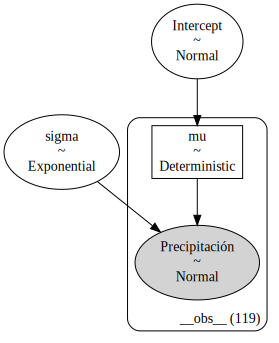

In [ ]:
# Construccion del Modelo Normal

# Prioris
prioris = {"Intercept": bmb.Prior("Normal",mu=np.log(150),sigma=1/6*np.log(150)),
"sigma":bmb.Prior("Exponential",lam=1/10)}

# Modelo
model_Norm2 = bmb.Model('Precipitación~1',data=df_max,family='gaussian',link='log',
                    priors=prioris)
model_Norm2.build()

# Visualizacion
model_Norm2.graph()

¡Siempre es importante graficar las prioris para verificar que la distribución a priori resultó la que ustedes querían! Es nuy común que `Bambi` no la tome, por ejemplo, por nombrar mal el parámetro en el diccionario. O que los valores en la priori no sean los que uno realmente quería introducir al problema.

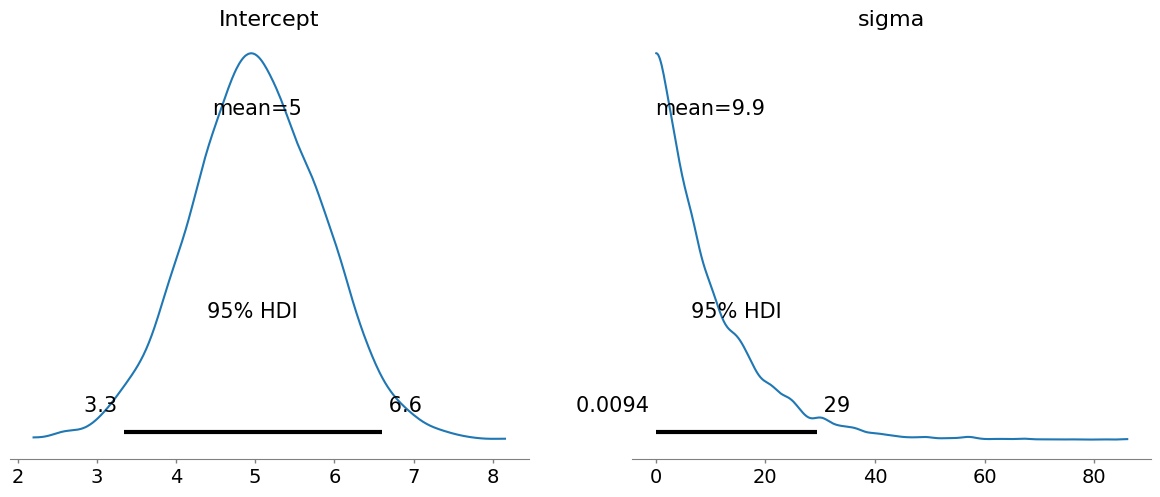

In [ ]:
# Graficar prioris
model_Norm2.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Un modelo Gamma

Las familias de `Bambi` me permiten elegir de una amplia variedad de modelos, por ejemplo, una gamma. Usarlo es sencillo, simplemente hay que prestar atención en la documentación para entender qué significa cada parámetro. En este caso, para el parámetro principal nos queda:

- Modelo

$$y \sim Gamma(m,\alpha)$$

- Fórmula

$$1/m = Intercept \cdot 1$$

- Prioris

$$p(Intercept) \sim ``Bambi"$$
$$p(\beta) \sim ``Bambi"$$

¡Y lo único que tengo que hacer es cambiar el `family` al construir el modelo!

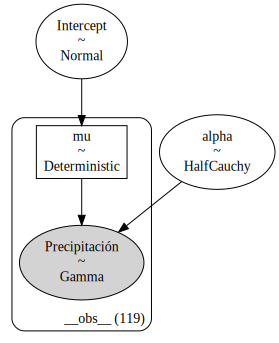

In [ ]:
# Construccion del Modelo Gamma
model_Gamma = bmb.Model('Precipitación~1',data=df_max,family='gamma')
model_Gamma.build()

# Visualizacion
model_Gamma.graph()

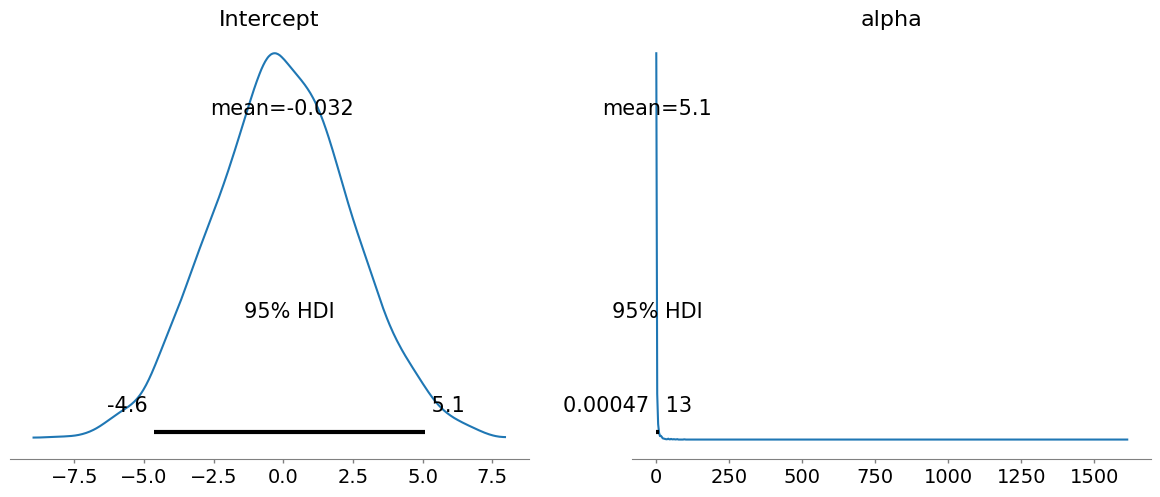

In [ ]:
# Graficar prioris
model_Gamma.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Modelo LogNormal

Otro modelo que se suele usar para este tipo de problemas es el LogNormal. Como la LogNormal es una familia muy utilizada y que tiene sus particularidades, es importante prestarle un poco de detalle.

Por un lado, la distribución LogNormal no está pre-cargada en `Bambi`. Si bien podríamos construirla nosotros de forma relativamente sencilla, en realidad lo más común es convertir el problema a uno Normal, ajustando el logaritmo de los datos.

Es decir, en vez de resolver

$$Y\sim LN(m,s)$$

vamos a usar el modelo

$$ln(Y) \sim N(m,s)$$

¡que es un típico modelo normal muy fácil de resolver! Para hacer esto no es necesario editar el dataframe con los datos, sino que simplemente puede hacerse a través de la fórmula, aclarando que se quiere ajustar el logaritmo de la columna en vez de la columna propiamente dicha

Entonces,

Modelo:

$$ln(y) \sim N(m,s)$$

Fórmula para el valor medio (del logaritmo):

$$m = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim ``Bambi"$$

$$p(s) \sim ``Bambi"$$

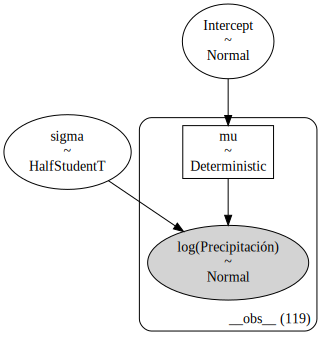

In [ ]:
# Construccion del Modelo lognormal

# Modelo
model_ln = bmb.Model('log(Precipitación)~1',data=df_max)

model_ln.build()
model_ln.graph()

Abajo pueden ver las ditribuciones a priori para `Intercept` y `sigma`.

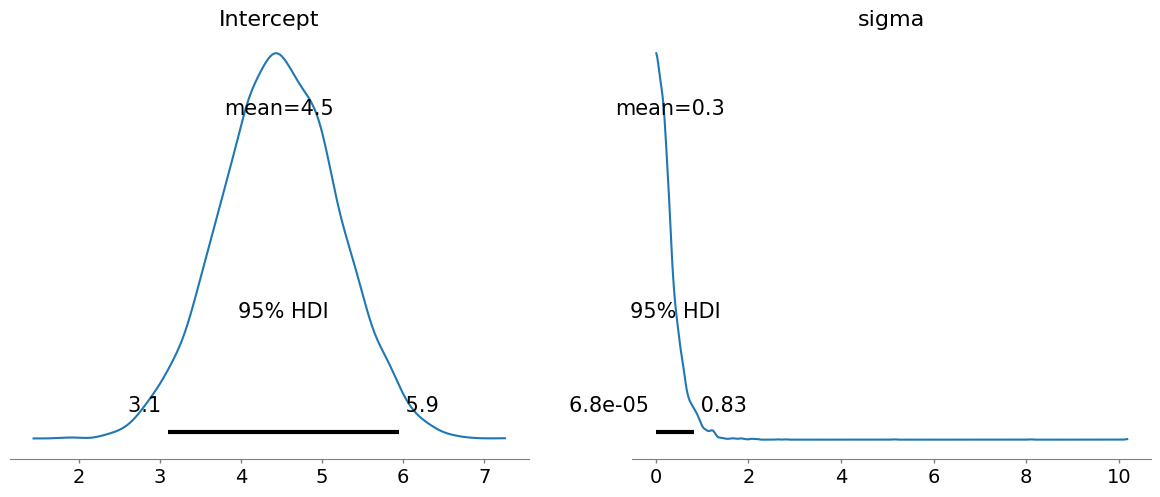

In [ ]:
model_ln.plot_priors(hdi_prob=0.95)
plt.show()

### Evaluación de las distribuciones a priori

Siempre es importante revisar qué impacto tienen nuestras distribuciones a priori en el modelo. Para eso podemos ver qué simula antes de ver los datos, y si resulta razonable.

El método de bambi `prior_predictive()` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.prior_predictive)) permite hacer nuevas simulaciones/predicciones de la variable utilizando sólo las distribuciones a priori, guardándolas en un Inference Data. Luego, con la función `plot_ppc` ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.plot_ppc.html) pueden graficarlas. Es importante aclarar `group='prior'` en este caso.

Noten que la forma de hacer las simulaciones es nuevamente como réplicas del ensayo, luego presentando la priori predictiva (el promedio de todas esos grupos de simulaciones).

**NOTA**: De aquí en más, vamos a trabajar con el modelo normal básico.

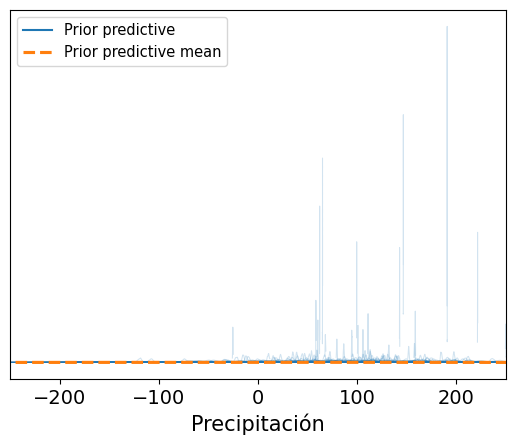

In [ ]:
# Simulaciones de la priori predictive
priorcheck_Norm = model_Norm.prior_predictive(draws=2000)

# Gráfico
az.plot_ppc(priorcheck_Norm,group='prior')
plt.xlim([-250, 250])
plt.show()

Recuerden que aquí estoy viendo qué predice mi modelo antes de ver los datos (usando la distribución a priori nada más). Me da una buena idea de qué hace mi distribución a priori en el modelo, que no siempre va a ser obvio.

**¿Viendo lo de arriba, les gustan las prioris adoptadas? ¿Qué sí y qué no?**

### Realizar la inferencia y evaluar convergencia

El siguiente paso, si vemos bien las prioris que elegimos, es proceder con la inferencia para obtener las distribuciones posteriores. Para ello usamos el método `fit()` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit)). Los variables clave que permite el método son:

- Draws: La cantidad de simulaciones por cadena
- Chains: La cantidad de cadenas (generalmente se hace una por núcleo disponible ya que permite simular en paralelo y ahorrar tiempo. Lo recomendable es hacer al menos 4 cadenas). El total de simulaciones con 8000 puede estar bien para algo sencillo.
- inference_method: El método de inferencia utilizada. Por default usa `MCMC`, pero se pueden usar métodos de inferencia variacional para datasets muy grandes que no puedan correr.
- Random_seed: Valor que me permite generar consistencia/manipular la aleatoriedad de las simulaciones.

Esto devuelve un Inference Data (veremos más adelante qué tiene dentro). Lo importante es revisar que la inferencia haya salido bien. Para ello hay que mirar.

- Que no haya divergencias (especialmente en modelos sencillas. Puede aceptarse algunas pocas en modelos complejos con muchos parámetros)
- Que las cadenas sean un ruido blanco sin tendencias o autocorrelación (que sean independientes)
- Que las cadenas hayan convergido y tenga similar variabilidad.

Esto puede hacerse en forma visual mediante la función `plot_trace` [LINK](https://python.arviz.org/en/latest/api/generated/arviz.plot_trace.html). La variable `compact=False` lo que hace es separar en ciertos casos los distintos parámetros simulados para mayor claridad en vez de agruparlos en un mismo gráfico. Debieran ver que las distribuciones posteriores de cada cadena se parezcan entre sí, y que las simulaciones parezcan un ruido blanco superpuesto horizontal.

Luego, el otro dato clave es el Coeficiente $R$, que compara la variable dentro de una misma cadena con la variabilidad entre cadenas. Este número debiera ser **muy** cercano a 1 (1.03 como mucho). ArviZ lo calcula por ustedes con la función `summary` [LINK](https://python.arviz.org/en/latest/api/generated/arviz.summary.html).

Output()

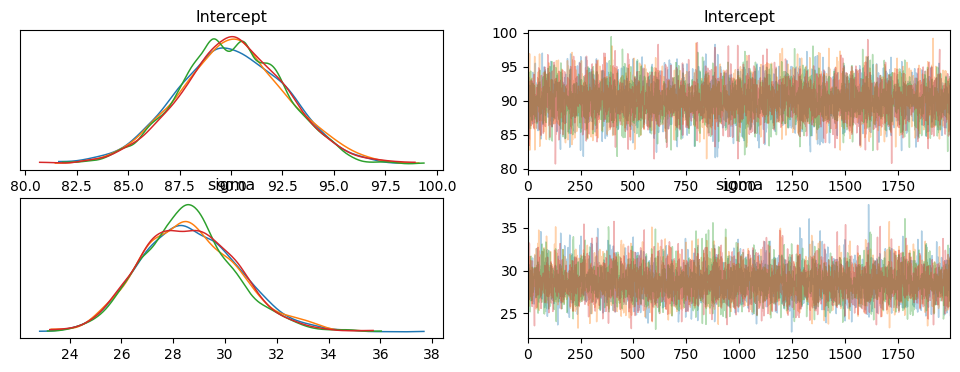

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,90.054,2.595,84.984,95.130,0.030,0.029,7541.0,5318.0,1.0
sigma,28.622,1.860,24.954,32.195,0.021,0.023,7904.0,5168.0,1.0


In [ ]:
# Hacer inferencia por MCMC
results_Norm = model_Norm.fit(draws=2000,chains=4)

# NOTA: Si quisiera hacer inferencia variacional (ejemplo: cuadrática-Laplace)
#results_Norm = model_Norm.fit(inference_method='Laplace')

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_Norm, compact=False)
plt.show()

# Numerico
az.summary(results_Norm,hdi_prob=0.95)

Como dijimos antes, la inferencia devuelve un Inference Data. Abajo pueden ver lo que tiene (¡es clickeable!)

- En `posterior` van a encontrar las simulaciones de la distribución posterior de los parámetros. Es una matriz de (#cadenas,#simulaciones). Después vemos como extraerla como un Numpy Array
- En `observed_data` van a encontrar los datos utilizados para la inferencia/predicción. Es una matriz de (#obs), también extraible como Numpy Array.

In [ ]:
results_Norm

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Distribución posterior

Si todo esta bien, ya podemos empezar a informar resultados de nuestra inferencia. La función `plot_posterior` (muy útil y versátil, [LINK](https://python.arviz.org/en/latest/api/generated/arviz.plot_posterior.html)) permite graficar, entre otras cosas la distribución posterior de los parámetros si le entregamos nuestro Inference Data. con `var_names` pueden definir como lista los parámetros que quieren graficar, y con `hdi_prob` el intervalo de confianza. La función devuelve un gráfico que incluye también aspectos claves de la distribución.

Esa misma información la pueden encontrar en forma de tabla con la función `summary` que vimos antes, que acepta las mismas variables para seleccionar parámetros e intervalos de confianza

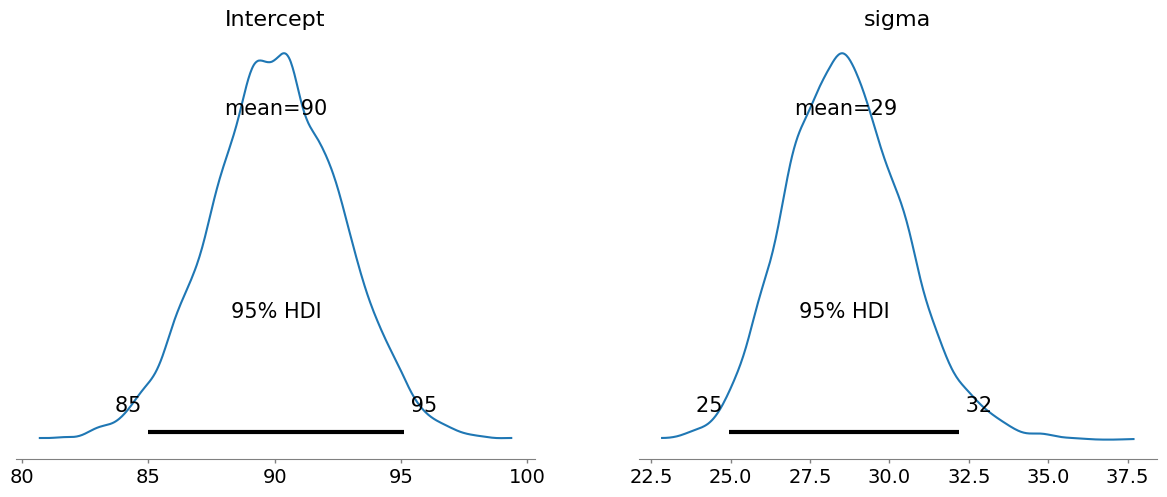

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,90.054,2.595,84.984,95.130,0.030,0.029,7541.0,5318.0,1.0
sigma,28.622,1.860,24.954,32.195,0.021,0.023,7904.0,5168.0,1.0


In [ ]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_Norm,hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_Norm,hdi_prob=0.95)

Como nota, es posible extraer los límites del intervalo de confianza con la función `hdi` de ArviZ ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.hdi.html)). Notarán que lo hice extrayendo los datos del Inference Data como matriz (ahora lo vemos bien como se hace). ¡Esto significa que la función sirve para cualquier vector de datos simulados!

In [ ]:
IC05,IC95 = az.hdi(np.ravel(results_Norm.posterior['Intercept'].values), hdi_prob=0.90)
print('Intervalo de confianza del 5%:',IC05)
print('Intervalo de confianza del 95%:',IC95)

Intervalo de confianza del 5%: 85.83804938053423
Intervalo de confianza del 95%: 94.32607488891531


### Distribución posterior predictiva (nuevas simulaciones)

Si quiero obtener nuevas simulaciones de cosas que no observé (años futuros en este caso), puedo hacerlo con el método `predict` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)). `kind='response'` indica que quiero simular no solo los parámetros del modelo sino también nuevos datos (si quisiera simular sólo los parámetros del modelo se haría con `kind='response_params'`, que es el default). Con `inplace=True` indico que quiero sobreescribir el Inference Data agregando las nuevas simulaciones, sin tener que guardarlo en una nueva variable.

Luego, la función `plot_ppc` que vimos antes permite gráficar las réplicas de mi ensayo, la posterior predictiva y comparar contra el histograma de los datos. Ya pueden empezar a ver qué tan probable es que su modelo genere algo parecido a sus datos.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


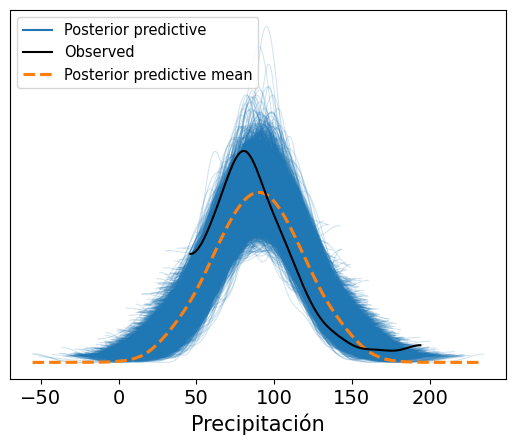

In [ ]:
# Nuevas simulaciones (lo guarda en la misma variable results_2 de antes con inplace=True)
model_Norm.predict(results_Norm, kind="response",inplace=True)

# Grafico
az.plot_ppc(results_Norm)
plt.show()

### Accediendo a las simulaciones

Como dijimos antes, el resultado de la inferencia y la predicción es un Inference Data. Verán que luego de predecir se agregó una nueva sección de nombre `posterior_predictive`. Allí van a encontrar las simulaciones de los datos/mi variable de interés, en tamaño (#cadenas,#simulaciones,#obs). Es decir, genera muchas réplicas de mi ensayo con el tamaño original de mis datos.

In [ ]:
results_Norm

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Estsa simulaciones pueden extraerse como Numpy Arrays para su manipulación o calculos (valores medios, cuantiles, cálculos de probabilidad, etc.

Abajo les dejamos como hacerlo para la posterior...

In [ ]:
results_Norm.posterior['Intercept'].values

array([[90.5272896 , 90.5272896 , 89.49797891, ..., 92.47342332,
        90.38221297, 89.15787819],
       [93.2298219 , 89.82013283, 89.82013283, ..., 90.07352045,
        90.07352045, 89.41305283],
       [89.35546816, 89.35546816, 88.93707501, ..., 93.51414627,
        86.46601559, 86.46601559],
       [89.85721079, 90.16660805, 91.82426836, ..., 88.00728179,
        88.00728179, 93.49827307]])

In [ ]:
results_Norm.posterior['sigma'].values

array([[27.99352552, 27.99352552, 27.86083847, ..., 26.54954223,
        28.61532312, 24.7499619 ],
       [29.47985577, 30.5761212 , 30.5761212 , ..., 28.01666388,
        28.01666388, 25.52120199],
       [31.71063333, 31.71063333, 27.24423156, ..., 28.5936311 ,
        27.64996415, 27.64996415],
       [27.99262495, 30.22359631, 32.10220271, ..., 27.2039619 ,
        27.2039619 , 30.15030963]])

Para la posterior predictiva...

In [ ]:
results_Norm.posterior_predictive['Precipitación'].values

array([[[ 81.13639654, 123.52631212, 126.05221336, ...,  49.42744766,
          58.34315763, 107.96647897],
        [ 72.02240159,  77.74741971, 131.34490145, ...,  44.16848135,
         142.1847271 ,  83.64647728],
        [125.19038358, 106.34719868,  51.19770071, ...,  88.3414591 ,
          89.33437188,  87.5381443 ],
        ...,
        [ 91.17960281,  94.23403012,  47.84664419, ..., 121.65417828,
          66.18226815,  89.38245747],
        [ 63.00938295,  60.75283602, 129.90489428, ...,  64.13126319,
          28.20638507, 133.95590873],
        [ 55.07646121,  32.67569169,  73.64456792, ...,  96.86191091,
         128.64869215, 115.90249879]],

       [[112.66959748,  54.14524979, 101.79241692, ...,  72.46904956,
          87.57848404,  88.92088075],
        [141.45556719,  80.65122445, 106.02350522, ..., 102.75261213,
          61.13060058,  41.49793969],
        [ 92.10770249,  88.14668762,  90.83096845, ..., 102.3798744 ,
          70.80004591, 128.57524962],
        ...,


Y para los datos observados que se usaron.

In [ ]:
results_Norm.observed_data['Precipitación'].values

array([ 80.6,  76.5,  73.4,  52.7,  51.7,  84.6, 166. ,  85.4, 108.5,
        97.2,  57.3,  79. ,  59.4,  78.9,  85.2,  72.4,  96. ,  52.2,
        71.2, 120.5,  61.6,  49.8, 129.1,  46. , 194.1,  57.8,  55.6,
        58. ,  64. ,  54.4,  83.8,  77.6,  63.9,  99.4, 138.2,  83.9,
        86.4,  82.2, 108.7, 103.6,  99.8,  82.3,  80.8,  64.2,  97. ,
       138.5, 100. ,  98.5,  77.3,  79.2,  71.5,  83.5,  68.3, 118.7,
        63.1,  87.6, 108.5,  76.1,  82.4,  62.8,  86.7,  81.5, 124.1,
        95.6,  60.8,  83.6,  76.9, 104.2, 172.7, 104.9,  90. ,  74.1,
        89.5,  89.4,  70.4,  78. , 107. ,  65.1,  84.3, 188.4,  61.6,
       109. ,  91.4, 142. , 115.6,  85.6, 111.9,  91.6,  68.7,  53.7,
        80.7, 100.7,  77.4, 101.8, 111.6, 145.5, 119.5, 116.3, 119. ,
        74.8,  96.7,  65.4,  60. ,  72.6,  92. ,  83. , 122. , 159. ,
       132. ,  85. ,  52. , 105. , 108. ,  71.4,  79.3,  72. , 101. ,
        69.1,  95. ])

### Uso del modelo (contestar preguntas)

Todo esto lo hicimos con una razón: contestar nuestra pregunta original.

- ¿Cuál es la lluvia que ocurre una vez (se supera) cada 100 años? O dicho más correctamente, la lluvia cuyo período de recurrencia es 100 años.

Extrayendo los datos como vimos antes, ¡ahora simplemente es un problema de conteo!

Recordemos que el período de retorno $T(x)$ es el tiempo promedio $T$ entre eventos que superan determinado valor de la variable $x$:

$$T(x) = \frac{1}{1-p(X\leq x)}$$

lo que considera que el tiempo promedio es la inversa de la probabilidad de excedencia.

En nuestro caso, el período de retorno es 100 años. Considerando cada año como independiente entre sí:

$$1-P(X\leq x_{mil})^{100} = \frac{1}{100}$$

Por lo tanto, la probabilidad de que la lluvia milenaria no se supere en un año es:

$$P(X \leq x_{100}) = \left(1 - \frac{1}{100}\right)^{\frac{1}{100}} $$

La lluvia centenaria es de: 200.0 mm


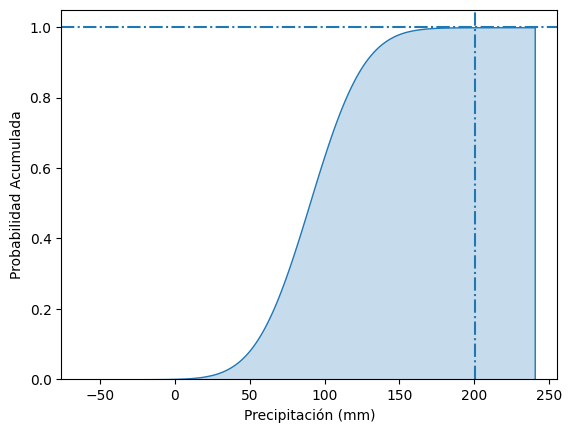

In [ ]:
# Accedo a los datos
Simul = results_Norm.posterior_predictive['Precipitación'].values

# Probabilidad de ocurrencia de lluvia menor a la milenaria en un año
P100 = (1-1/100)**(1/100)

# Cuantil de lluvia asociado a esa probabilidad
Lluvia = np.quantile(np.ravel(Simul),P100)
print('La lluvia centenaria es de:',round(Lluvia,0),'mm')

sns.kdeplot(np.ravel(Simul),cumulative=True,fill=True)
plt.axhline(P100,ls='-.')
plt.axvline(Lluvia,ls='-.')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Probabilidad Acumulada')
plt.show()

### ¿Qué pasaba si usaba otro modelo para contestar?

Como verán, la respuesta a mi pregunta no depende sólo de mis datos, sino también del modelo que yo elijo para explicar mis datos. Por lo tanto, jueguemos un poco y contestemos la pregunta usando ahora el modelo lognormal.

Recordemos cómo era:

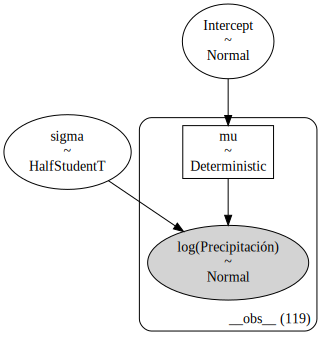

In [ ]:
# Visualizar
model_ln.graph()

#### Construcción Rápida

Luego de chequear las distribuciones a priori, el primer paso es hacer la inferencia y verificar la convergencia.

Output()

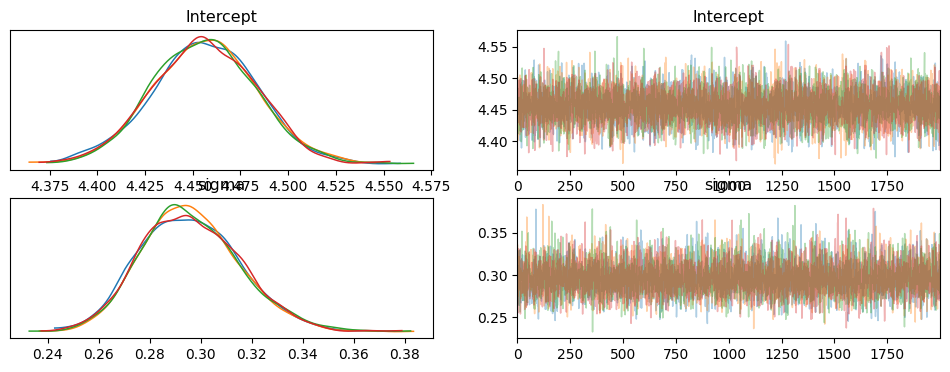

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.456,0.027,4.402,4.508,0.0,0.0,8694.0,6034.0,1.0
sigma,0.296,0.019,0.260,0.335,0.0,0.0,7992.0,6004.0,1.0


In [ ]:
# Hacer inferencia por MCMC
results_ln = model_ln.fit(draws=2000,chains=4)

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_ln, compact=False)
plt.show()

# Numerico
az.summary(results_ln,hdi_prob=0.95)

Luego, miro la distribución posterior de los parámetros:

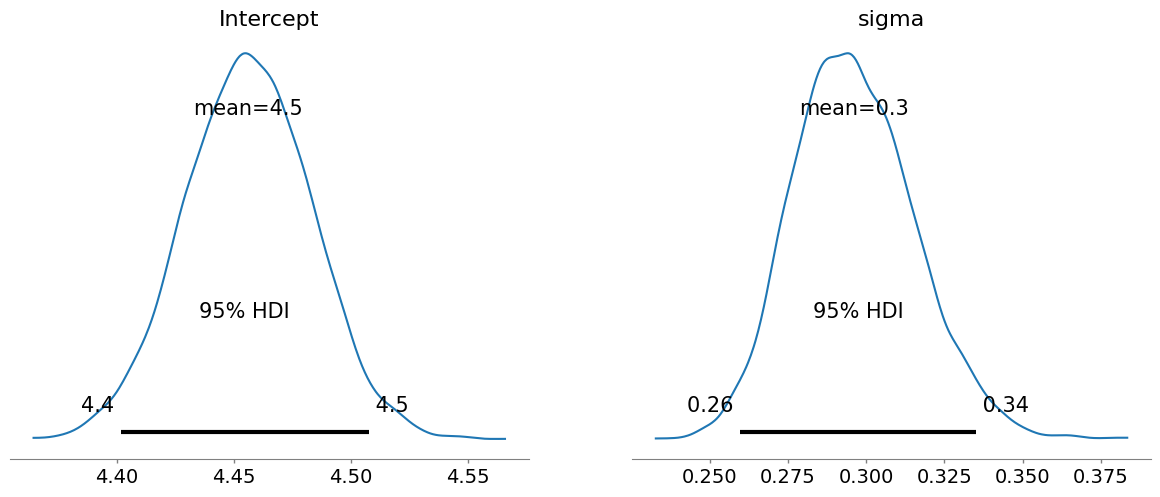

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.456,0.027,4.402,4.508,0.0,0.0,8694.0,6034.0,1.0
sigma,0.296,0.019,0.260,0.335,0.0,0.0,7992.0,6004.0,1.0


In [ ]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_ln,hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_ln,hdi_prob=0.95)

Y, luego, puedo generar nuevas simulaciones de lluvia (posterior predictiva) y chequear el modelo.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


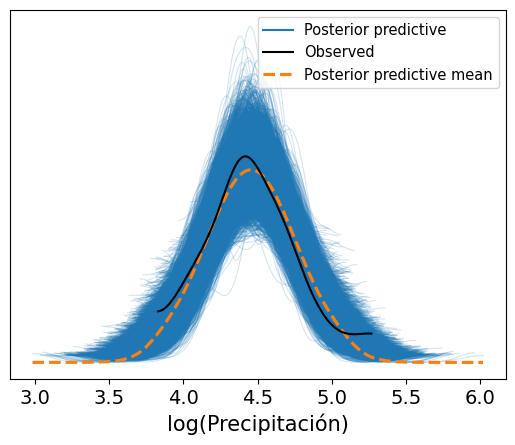

In [ ]:
# Nuevas simulaciones (lo guarda en la misma variable results_ln de antes con inplace=True)
model_ln.predict(results_ln, kind="response",inplace=True)

# Grafico
az.plot_ppc(results_ln)
plt.show()

Notarán que el modelo devuelve simulaciones del logaritmo de las lluvias, porque ¡eso es lo que ajuste!

#### Aplicacion de transformacion a las simulaciones

Es necesario entonces, transformar los datos (y cambiarles el nombre para dejarlo de manifiesto). Esto puede hacerse con los métodos `map` ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.map.html#arviz.InferenceData.map)) y `rename` ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.rename.html)) de ArviZ.

Abajo les dejamos como hacerlo. Lo recomendable es generar un nuevo Inference Data (con `inplace=False` y guardándolo en una nueva variable). Noten que esto sirve para cualquier tipo de transformación.

In [ ]:
# Transformar resultados de Y a escala deseada
results_ln_T = results_ln.map(lambda x: np.exp(x), groups="observed_vars",
                                  inplace=False)

# Renombrar variable de log(X) a X luego de aplicar transformacion
results_ln_T.rename(name_dict={'log(Precipitación)':'Precipitación'}, inplace=True)

results_ln_T

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Y ahora sí el chequeo de la priori predictiva está en mi escala original y es comparable con el modelo normal.

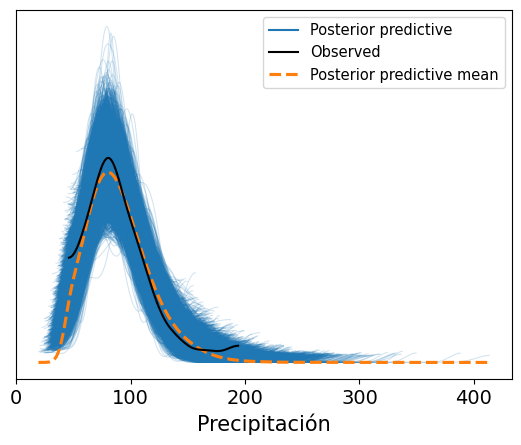

In [ ]:
# Grafico
az.plot_ppc(results_ln_T)
plt.show()

¿Qué modelo parece ajustar mejor?

#### Uso del modelo (contestar preguntas)

Todo esto lo hicimos con una razón: contestar nuestra pregunta original.

- ¿Cuál es la lluvia que ocurre una vez (se supera) cada 100 años? O dicho más correctamente, la lluvia cuyo período de recurrencia es 100 años.

¿Cuánto dará si adopto el modelo lognormal?

La lluvia centenaria es de: 268.0 mm


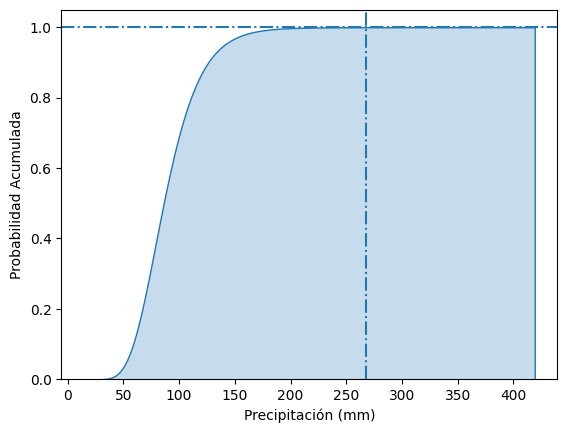

In [ ]:
# Accedo a los datos
Simul = results_ln_T.posterior_predictive['Precipitación'].values

# Probabilidad de ocurrencia de lluvia menor a la milenaria en un año
P100 = (1-1/100)**(1/100)

# Cuantil de lluvia asociado a esa probabilidad
Lluvia = np.quantile(np.ravel(Simul),P100)
print('La lluvia centenaria es de:',round(Lluvia,0),'mm')

sns.kdeplot(np.ravel(Simul),cumulative=True,fill=True)
plt.axhline(P100,ls='-.')
plt.axvline(Lluvia,ls='-.')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Probabilidad Acumulada')
plt.show()

¡30% más! Así que es importante definir qué modelo se ajusta mejor a los datos antes de avanzar.

## Ejemplo 2: Sismos en San Juan (soluciones por MCMC)

En este ejemplo vamos a seguir el ajuste de un modelo para predecir el número de sismos en la Provincia de San Juan por año.

La pregunta que queremos contestar es:

- ¿Cuál es la probabilidad de que no haya sismos de magnitud moderada en los próximos 5 años?

Para ello, descargamos de la página de [USGS](https://earthquake.usgs.gov/earthquakes/search/), los datos de los últimos 81 años.

Abajo pueden ver la limpieza de datos, que nos lleva a quedarnos únicamente con 48 años de datos.

### Limpieza de los datos (Off Road)

Para el que le interesa, a continuación les dejamos todo el proceso de convertir los datos descargados en algo "útil" para trabajar, tema que excede largamente a los objetivos del curso.

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving Sismos_SanJuan.csv to Sismos_SanJuan.csv


In [ ]:
#Se crea un DataFrame
df_sismos = pd.read_csv(io.BytesIO(uploaded['Sismos_SanJuan.csv']))
df_sismos.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-12-27T13:01:04.080Z,-31.2940,-69.3336,109.05,4.5,mb,NaN,66.0,0.609,0.77,...,2022-03-05T23:10:45.040Z,"9 km ENE of Calingasta, Argentina",earthquake,4.6,5.8,0.314,3.0,reviewed,us,us
1,2021-12-08T23:36:02.742Z,-31.8741,-68.3598,112.11,4.0,mb,NaN,115.0,0.288,1.04,...,2022-02-12T23:07:04.040Z,"22 km S of Nueve de Julio, Argentina",earthquake,8.2,4.3,0.184,8.0,reviewed,us,us
2,2021-11-25T03:18:30.863Z,-32.7200,-70.1864,112.84,4.0,mb,NaN,109.0,0.310,0.43,...,2022-01-29T22:55:53.040Z,"40 km ENE of Los Andes, Chile",earthquake,2.7,8.1,0.298,3.0,reviewed,us,us
3,2021-11-18T01:09:40.958Z,-31.2685,-69.0364,106.72,4.5,mb,NaN,47.0,0.408,0.65,...,2022-01-22T20:52:00.040Z,"37 km ENE of Calingasta, Argentina",earthquake,5.8,5.4,0.140,15.0,reviewed,us,us
4,2021-11-03T03:17:48.635Z,-32.6971,-70.0638,100.25,5.7,mww,NaN,18.0,0.415,0.77,...,2022-01-14T17:58:56.040Z,Chile-Argentina border region,earthquake,4.6,1.3,0.041,58.0,reviewed,us,us


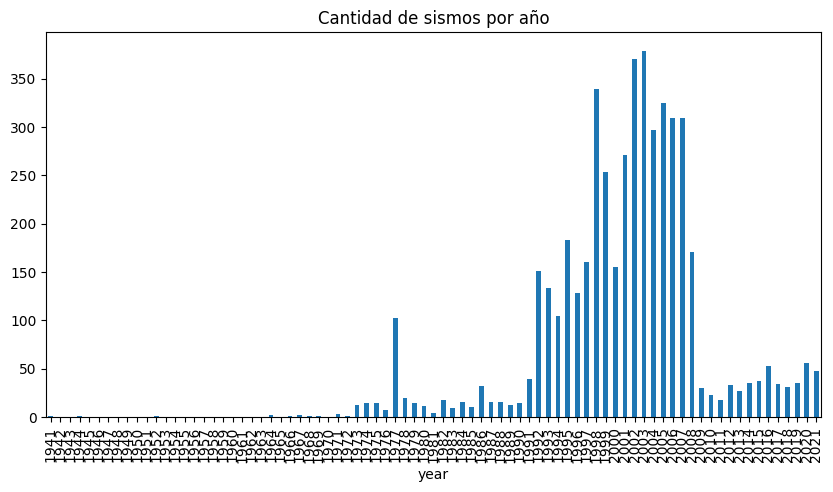

In [ ]:
# Convertir a datetime
df_sismos['time'] = pd.to_datetime(df_sismos['time'])

# Conteo por año
Data = df_sismos.groupby(pd.Grouper(key='time', freq='YE'))['mag'].count().reset_index()

# Limpieza
Data['year'] = Data['time'].dt.year
Data = Data.rename(columns={'mag':'sismos'})
Data = Data.drop(columns='time')

# Grafico
Data.plot(x='year', y='sismos',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

¿Notan algo raro? ¿Cómo puede ser que haya explotado el número de sismos de repente?

Acá es donde entra en juego el conocimiento del fenómeno físico. Uno ve los datos de arriba y se ven claramente cuatro grandes regiones: Una hasta el 73, otra hasta el 92 y un último quiebre en la información en 2008.

Esto no es porque la sismicidad de San Juan haya cambiado significativamente en estos 50 años, sino que es una consecuencia de los cambios en la instrumentación de la región y los sismos que se informan y recolecta USGS.

Una forma fácil de chequear que el dataset así como está no sigue una distribución de poisson es si $\mu\not=\sigma^2$ (es una propiedad de la misma).

In [ ]:
# Chequear media y varianza
mu1 = Data['sismos'].mean()
s1 = Data['sismos'].var()
print('media',mu1)
print('varianza',s1)

media 60.53086419753087
varianza 10444.25216049383


¡Nada que ver! Pero esperá... pensemos cómo limpiar los datos.

1. Los datos anteriores a 1974 están claramente incompletos (no había datos)
2. Vamos a quedarnos sólo con los sismos "grandes" (mayores a Magnitud 5), porque los otros no se solían informar.

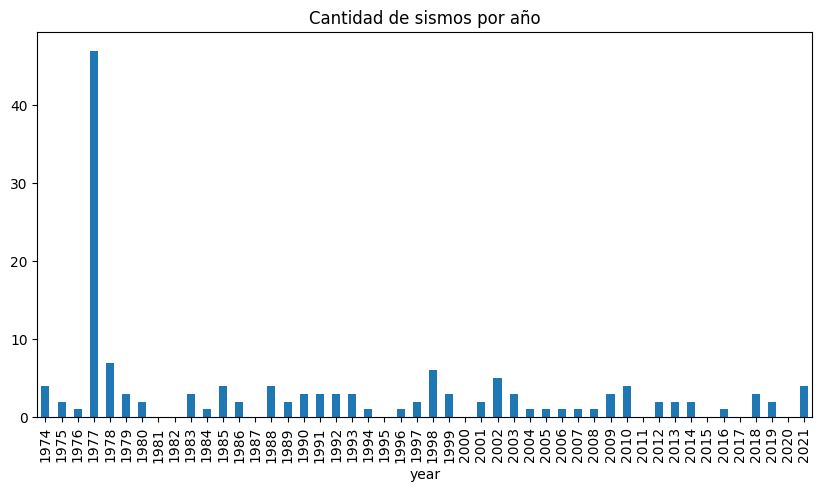

media 3.0208333333333335
varianza 44.701684397163135


In [ ]:
## Filtrar datos anteriores a 1973 y con M < 5
Filter = (df_sismos['time']>pd.Timestamp('1974-01-01',tz='GMT+0'))*(df_sismos['mag']>5.)
df_sismosF = df_sismos[Filter]

# Conteo por año
Data = df_sismosF.groupby(pd.Grouper(key='time', freq='YE'))['mag'].count().reset_index()

# Limpieza
Data['year'] = Data['time'].dt.year
Data = Data.rename(columns={'mag':'sismos'})
Data = Data.drop(columns='time')

# Grafico
Data.plot(x='year', y='sismos',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

# Chequear media y varianza
mu1 = Data['sismos'].mean()
s1 = Data['sismos'].var()
print('media',mu1)
print('varianza',s1)

¡Mejor! Pero sigue sin parecerse a una Poisson.

¿Pero no notan algo raro? ¿Qué pasó en San Juan en 1977?

¡Claro! El sismo de Caucete. Lo que estoy viendo ahí son **todas las réplicas**. Esos eventos no son independientes, tengo que eliminarlos. ¿Cómo?

Como este no es un curso de análisis sísmico, no entraremos al detalle de como filtrar el dataset, pero pueden encontrarlo en Gardner and Knopoff (1974). En resumen, se mira un ventana espacio-temporal que es función de la magnitud para generar un cluster de sismos, y aquel de mayor magnitud es el evento principal y resto son réplicas, eliminandose del dataset.

**Gardner, J. K., & Knopoff, L. (1974). Is the sequence of earthquakes in Southern California, with aftershocks removed, Poissonian?. Bulletin of the seismological society of America, 64(5), 1363-1367.*

In [ ]:
# Gardner Knopoff (1974)

# Distancia en base a latitud y longitud de 2 puntos
def distance_d(LaA, LaB, LoA, LoB):
  # Pasar a Radianes
  LoA = np.radians(LoA)
  LoB = np.radians(LoB)
  LaA= np.radians(LaA)
  LaB = np.radians(LaB)
  # "Haversine formula"
  D_Lo = LoB - LoA
  D_La = LaB - LaA
  P = np.sin(D_La / 2)**2 + np.cos(LaA) * np.cos(LaB) * np.sin(D_Lo / 2)**2
  Q = 2 * np.arcsin(np.sqrt(P))
  # Radio de la tierra en km
  R_km = 6371

  # Distancia en km
  return(Q * R_km)

# Valores de distancia y tiempo limites para chequear eventos
from scipy.interpolate import interp1d
M = np.linspace(2.5,8.0,12)
Tval = np.array([6,11.5,22,42,83,155,290,510,790,915,960,985])
Rval = np.array([19.5,22.5,26,30,35,40,47,54,61,70,81,94])

# Interpolacion lineal para otras magnitudes
Tthre = interp1d(M,Tval)
Rthre = interp1d(M,Rval)

# Inicializar una nueva columna que indique si es Main Shock (1) o no (2)
df_sismos['Main'] = np.zeros(df_sismos.shape[0])
# Iterar sobre los sismos
for i in range(df_sismos.shape[0]):
  # Chequear que no haya sido descartado por otra ventana
  if df_sismos['Main'][i] != 2:
    Mi = df_sismos['mag'][i] # Magnitud del sismo
    Ti = Tthre(Mi) # Ventana de tiempo
    Ri = Rthre(Mi) # Radio a considerar

    # Encontrar todos los sismos dentro de la ventana espacio-temporal
    Time = df_sismos['time'][i] # Dia del sismo i
    DeltaT = df_sismos['time'] - Time # Tiempo entre sismos
    DeltaT = DeltaT.dt.days # Tiempo en dias

    # Latitudes y Longitudes
    LaA = df_sismos['latitude'][i]
    LaB = df_sismos['latitude']
    LoA = df_sismos['longitude'][i]
    LoB = df_sismos['longitude']

    # Distancia entre epicentros
    Dist = distance_d(LaA,LaB,LoA,LoB)

    # Sismos a chequear
    FiltCheck = (np.abs(DeltaT)<Ti)*(Dist<Ri)

    # Verificar que califica como Main Shock
    if (Mi>=df_sismos['mag'][FiltCheck]).all() == True:
      # Descartar Cluster
      df_sismos.loc[FiltCheck,'Main'] = 2
      # Definir Main Shock
      df_sismos.loc[i,'Main'] = 1

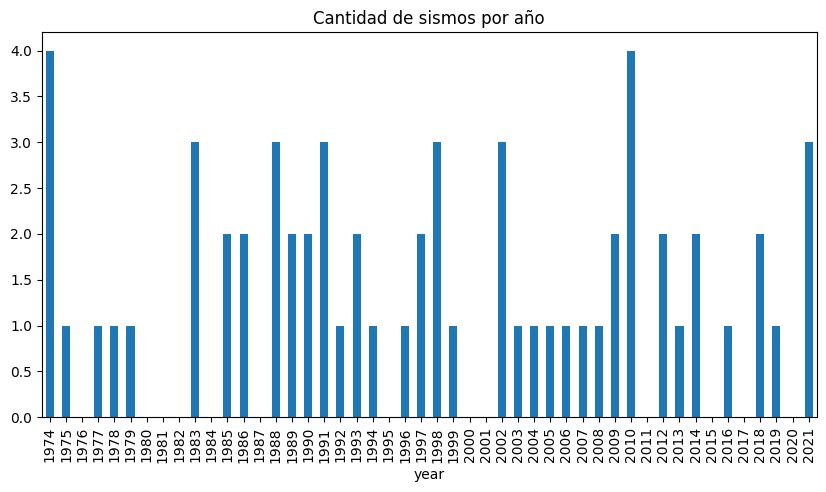

media 1.3125
varianza 1.2832446808510638


In [ ]:
# Definir Dataset filtrado final
FinalF = (df_sismos['Main'] == 1)*(df_sismos['mag']>5)*(df_sismos['time']>pd.Timestamp('1974-01-01',tz='GMT+0'))
df_sismosFinal = df_sismos[FinalF]

# Conteo por año
Data = df_sismosFinal.groupby(pd.Grouper(key='time', freq='YE'))['mag'].count().reset_index()

# Limpieza
Data['year'] = Data['time'].dt.year
Data = Data.rename(columns={'mag':'sismos'})
Data = Data.drop(columns='time')

# Grafico
Data.plot(x='year', y='sismos',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

# Chequear media y varianza
mu1 = Data['sismos'].mean()
s2 = Data['sismos'].var()
print('media',mu1)
print('varianza',s2)

Miren ahora como en 1977 en realidad solo hubo 1 sismo independiente. ¡Los otros 39 eran réplicas de ese!

Y noten ahora como estos datos filtrados efectivamente cumplen con una de las propiedades de la distribución de Poisson.

¡Nos faltaría chequear nada más que son independientes!

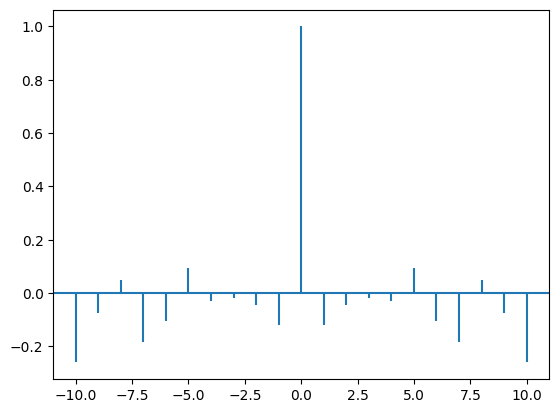

In [ ]:
# Autocorrelación
plt.acorr( Data['sismos']-Data['sismos'].mean() );

¡Efectivamente lo son! (o pareciera). Así que decir que el modelo que generó los datos es una distribución de Poisson es razonable.

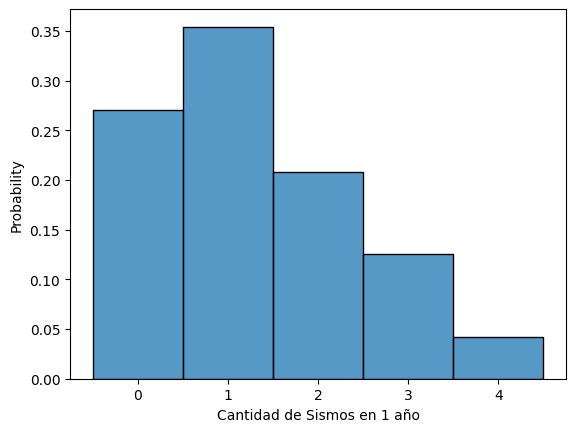

In [ ]:
sns.histplot(Data['sismos'],label='Sismos por año',stat='probability',discrete=True)
#plt.legend()
plt.xlabel('Cantidad de Sismos en 1 año')
plt.show()

#### Resumen

En resumen, el dataset trabajado que vamos a utilizar es el siguiente:

In [ ]:
# Dataset limpiado
Data

,sismos,year
0,4,1974
1,1,1975
2,0,1976
3,1,1977
4,1,1978
5,1,1979
6,0,1980
7,0,1981
8,0,1982
9,3,1983


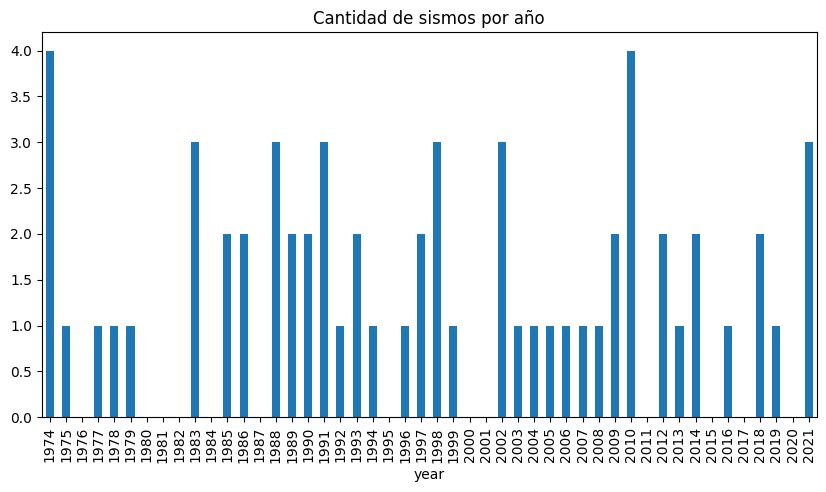

In [ ]:
# Grafico
Data.plot(x='year', y='sismos',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

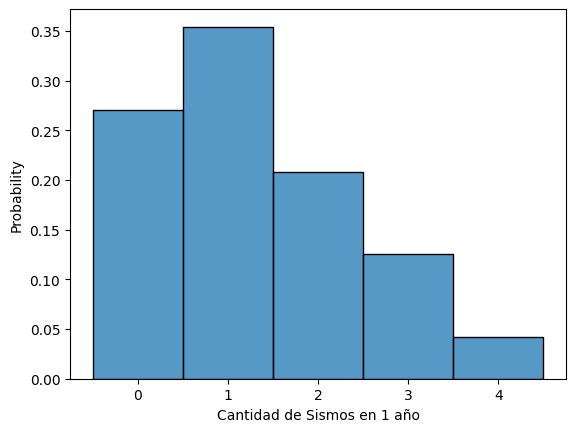

In [ ]:
sns.histplot(Data['sismos'],label='Sismos por año',stat='probability',discrete=True)
#plt.legend()
plt.xlabel('Cantidad de Sismos en 1 año')
plt.show()

### Construcción del modelo en Bambi

Vamos a contestar las preguntas resolviendo la inferencia por Cadenas de Markov, ya que nos va a dar más flexibilidad para plantear problemas más complejos y más libertad para elegir distribuciones a priori.

#### Ejemplo: El default para una Poisson

La construcción de un modelo de Bambi se hace con la función `Model` (LINK [link text](https://bambinos.github.io/bambi/api/Model.html#bambi.Model)). Hay 3 cosas a definir:
- La Fórmula: Es la ecuación que describe al parámetro "valor medio" (o una transformación de este) de la distribución elegida
- La Familia: Qué función de distribución define la verosimilitud
- El Link: Qué transformación aplica a la fórmula (¿Es para el el valor medio? ¿El logaritmo del valor medio? ¿su inversa?)
- Las distribuciones a priori: `Bambi` tiene opciones poco informativas si todo está por default. La recomendación es adoptarlas ustedes.

La familia por default en `Bambi` es el modelo Normal, pero tiene varios modelos ya pre-cargados (por ejemplo, el modelo de Poisson). Cada familia tiene, a su vez, un Link por default. En el caso de Poisson es `log`. Es decir, que estoy ajustando al logaritmo del valor medio:

Modelo:

$$y \sim Poisson(\lambda)$$

Fórmula para el valor medio (a las constantes, `Bambi` las llama `Intercept`:

$$ln(\lambda) = Intercept \cdot 1$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(\mu,\sigma)$$

La información anterior respecto a las familias cargadas en `Bambi`y sus `links`por default pueden verla [AQUÍ](https://bambinos.github.io/bambi/notebooks/getting_started.html#families)

A continuación, les dejamos un ejemplo de la carga de datos. Vean que los datos provienen de un dataframe, y la formula describe a la columna `mag` del dataframe, que es mi variable `y`.

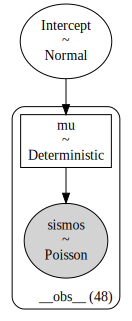

In [ ]:
# Construccion del Modelo de Poisson
model_1 = bmb.Model('sismos~1',data=Data,family='poisson')
model_1.build()

# Visualizacion
model_1.graph()

Con el método `plot_priors` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors)) podemos ver la distribución a priori adoptada. Si queremos ver el intervalo de confianza, con `hdi_prob` podemos setearlo. Podrán ver que la priori de `Bambi` suele ser muy poco informativa.

*Nota*: Recuerden que `Intercept`es el logaritmo del valor medio en este caso.

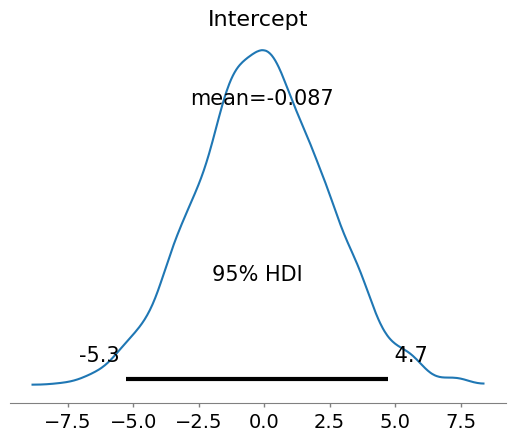

In [ ]:
# Graficar distribuciones a priori
model_1.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Detallando las distribuciones a priori y el parámetro a ajustar

Ahora vamos a hacer lo mismo pero definiendo nosotros el link y adoptando nuestra propia distribución a priori para el `Intercept` ($\lambda$). Sabemos que $\lambda$ es positivo. Si, por ejemplo, pensamos que debe estar entre 0.5 y 4.5, y queremos usar una distribución LogNormal sabemos que:

Valor Medio: $\mu = 2.5$

Desvío: $\sigma = 1$

Por lo tanto, el coeficiente de variación es $s = \mu/\sigma = 0.4$.

Finalmente, entonces el parámetro $m$ (el logaritmo de la mediana) es: $m = ln(\mu) - s^{2}/2 = 0.84$

El modelo que queremos construir entonces es:

Modelo:

$$y \sim Poisson(\lambda)$$

Fórmula para el valor medio:

$$\lambda = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim LN(m,s)$$

Abajo les dejamos cómo se hace en `Bambi`. Noten que las prioris se cargan como un diccionario, y la importancia de aclarar el `link`.

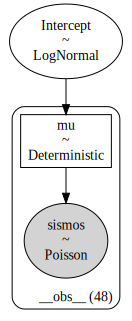

In [ ]:
# Valor Medio
med = 2.5

# Desvio para conseguir intervalo de confianza
des = (4.5-0.5)/4

# Parametro s (coeficiente de variacion)
s = des/med

# Parametro m (logaritmo de la mediana)
m = np.log(med)-0.5*s**2

# Construccion del Modelo de Poisson

# Prioris
prioris = {"Intercept": bmb.Prior("Lognormal",mu=m,sigma=s)}

# Modelo
model_2 = bmb.Model('sismos~1',data=Data,family='poisson',link='identity',
                    priors=prioris)
model_2.build()

# Visualizacion
model_2.graph()

¡Siempre es importante graficar las prioris para verificar que la distribución a priori resultó la que ustedes querían! Es nuy común que `Bambi` no la tome, por ejemplo, por nombrar mal el parámetro en el diccionario. O que los valores en la priori no sean los que uno realmente quería introducir al problema.

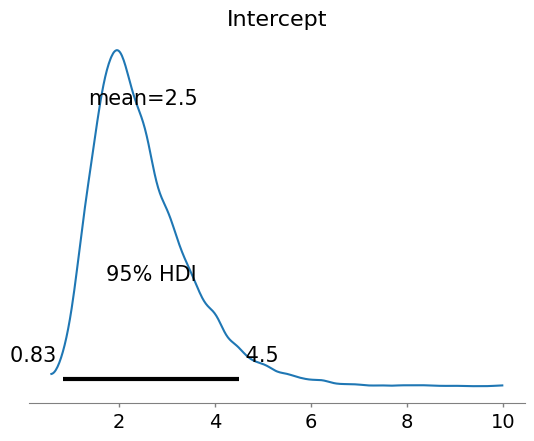

In [ ]:
# Graficar prioris
model_2.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Si quisiera hacer inferencia sobre el logaritmo del parámetro

A continuación se deja el mismo ejemplo/caso de arriba. Pero explicitamente modelando al logaritmo de $\lambda$. Recordando que si una V.A es lognormal, su logaritmo es Normal, el modelo sería:

Modelo:

$$y \sim Poisson(\lambda)$$

Fórmula para el valor medio:

$$ln(\lambda) = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(m,s)$$

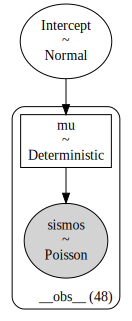

In [ ]:
# Construccion del Modelo de Poisson
# Prioris
prioris = {"Intercept": bmb.Prior("Normal",mu=m,sigma=s)}

# Modelo
model_2B = bmb.Model('sismos~1',data=Data,family='poisson',link='log',
                    priors=prioris)
model_2B.build()

# Visualizacion
model_2B.graph()

Comparando contra el primer ejemplo, pueden ver que la priori default de `Bambi` es mucho menos informativa que la que indicamos nosotros en el ejercicio.

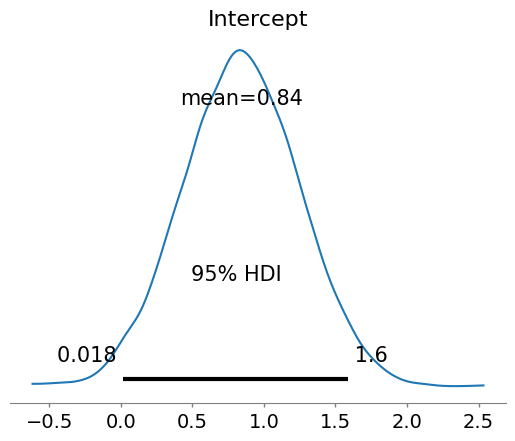

In [ ]:
# Grafico prioris
model_2B.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Construyendo "de 0" la familia/modelo de generación de datos

Existen situaciones donde la función de verosimilitud no está pre-cargada en `Bambi` (por ejemplo, la LogNormal o el modelo de Gumbel). En esos casos es posible construir manualmente una Familia.

Para construir una Familia, deben indicar cuál es la función de Verosimilitud (del listado de funciones disponibles en `PyMC`), y cuál es el parámetro principal (para el cual se escribe la fórmula, suele ser el valor medio de la distribución). Deben indicar también los `links` por default o posibles para el parámetro.

Como la familia es construida, va a ser necesario obligatoriamente definir nosotros las distribuciones a priori. Abajo les dejamos un ejemplo construyendo la familia Poisson de 0 nosotros, que les puede servir en el Trabajo Final. Como comentario, notaran que estamos usando como priori la distribución Gamma.

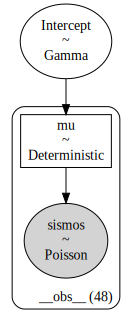

In [ ]:
# Definir la función de verosimilitud, indicando el parámetro principal
likelihood = bmb.Likelihood("Poisson", params=["mu"], parent="mu")

# Definir los links de los parámetros
link = {"mu": "identity"}

# Construir la familia a mano
family = bmb.Family("poisson_ICDIC", likelihood, link)

# Definir las prioris
prioris = {"Intercept": bmb.Prior("Gamma",alpha=6.25,beta=2.5)}

model_3 = bmb.Model("sismos~1", Data, family=family,priors=prioris)
model_3.build()

# Ver el modelo
model_3.graph()

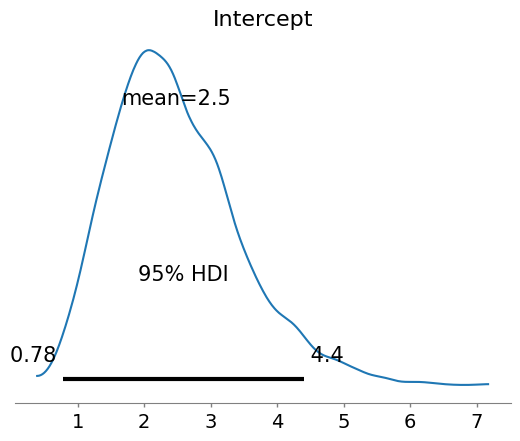

In [ ]:
# Grafico prioris
model_3.plot_priors(hdi_prob=0.95)
plt.show()

### Evaluación de las distribuciones a priori

Siempre es importante revisar qué impacto tienen nuestras distribuciones a priori en el modelo. Para eso podemos ver qué simula antes de ver los datos, y si resulta razonable.

El método de bambi `prior_predictive()` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.prior_predictive)) permite hacer nuevas simulaciones/predicciones de la variable utilizando sólo las distribuciones a priori, guardándolas en un Inference Data. Luego, con la función `plot_ppc` ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.plot_ppc.html) pueden graficarlas. Es importante aclarar `group='prior'` en este caso.

Noten que la forma de hacer las simulaciones es nuevamente como réplicas del ensayo, luego presentando la priori predictiva (el promedio de todas esos grupos de simulaciones).

**NOTA**: De aquí en más, vamos a trabajar con el modelo 2.

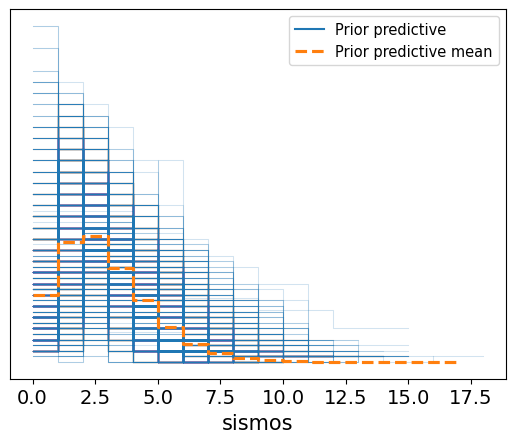

In [ ]:
# Simulaciones de la priori predictive
priorcheck_2 = model_2.prior_predictive(draws=2000)

# Gráfico
az.plot_ppc(priorcheck_2,group='prior')
plt.show()

Recuerden que aquí estoy viendo qué predice mi modelo antes de ver los datos (usando la distribución a priori nada más). Me da una buena idea de qué hace mi distribución a priori en el modelo, que no siempre va a ser obvio.

### Realizar la inferencia y evaluar convergencia

El siguiente paso, si vemos bien las prioris que elegimos, es proceder con la inferencia para obtener las distribuciones posteriores. Para ello usamos el método `fit()` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit)). Los variables clave que permite el método son:

- Draws: La cantidad de simulaciones por cadena
- Chains: La cantidad de cadenas (generalmente se hace una por núcleo disponible ya que permite simular en paralelo y ahorrar tiempo. Lo recomendable es hacer al menos 4 cadenas). El total de simulaciones con 8000 puede estar bien para algo sencillo.
- inference_method: El método de inferencia utilizada. Por default usa `MCMC`, pero se pueden usar métodos de inferencia variacional para datasets muy grandes que no puedan correr.
- Random_seed: Valor que me permite generar consistencia/manipular la aleatoriedad de las simulaciones.

Esto devuelve un Inference Data (veremos más adelante qué tiene dentro). Lo importante es revisar que la inferencia haya salido bien. Para ello hay que mirar.

- Que no haya divergencias (especialmente en modelos sencillas. Puede aceptarse algunas pocas en modelos complejos con muchos parámetros)
- Que las cadenas sean un ruido blanco sin tendencias o autocorrelación (que sean independientes)
- Que las cadenas hayan convergido y tenga similar variabilidad.

Esto puede hacerse en forma visual mediante la función `plot_trace` [LINK](https://python.arviz.org/en/latest/api/generated/arviz.plot_trace.html). La variable `compact=False` lo que hace es separar en ciertos casos los distintos parámetros simulados para mayor claridad en vez de agruparlos en un mismo gráfico. Debieran ver que las distribuciones posteriores de cada cadena se parezcan entre sí, y que las simulaciones parezcan un ruido blanco superpuesto horizontal.

Luego, el otro dato clave es el Coeficiente $R$, que compara la variable dentro de una misma cadena con la variabilidad entre cadenas. Este número debiera ser **muy** cercano a 1 (1.03 como mucho). ArviZ lo calcula por ustedes con la función `summary` [LINK](https://python.arviz.org/en/latest/api/generated/arviz.summary.html).

Output()

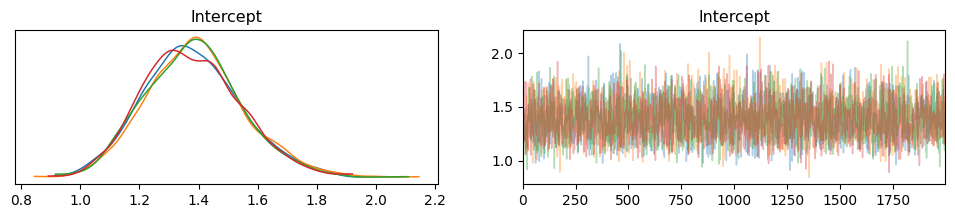

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.382,0.164,1.06,1.7,0.003,0.002,3506.0,5038.0,1.0


In [ ]:
# Hacer inferencia por MCMC
results_2 = model_2.fit(draws=2000,chains=4)

# NOTA: Si quisiera hacer inferencia variacional (ejemplo: cuadrática-Laplace)
#results_2 = model_2.fit(inference_method='Laplace')

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_2, compact=False)
plt.show()

# Numerico
az.summary(results_2,hdi_prob=0.95)

Como dijimos antes, la inferencia devuelve un Inference Data. Abajo pueden ver lo que tiene (¡es clickeable!)

- En `posterior` van a encontrar las simulaciones de la distribución posterior de los parámetros. Es una matriz de (#cadenas,#simulaciones). Después vemos como extraerla como un Numpy Array
- En `observed_data` van a encontrar los datos utilizados para la inferencia/predicción. Es una matriz de (#obs), también extraible como Numpy Array.

In [ ]:
results_2

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Distribución posterior

Si todo esta bien, ya podemos empezar a informar resultados de nuestra inferencia. La función `plot_posterior` (muy útil y versátil, [LINK](https://python.arviz.org/en/latest/api/generated/arviz.plot_posterior.html)) permite graficar, entre otras cosas la distribución posterior de los parámetros si le entregamos nuestro Inference Data. con `var_names` pueden definir como lista los parámetros que quieren graficar, y con `hdi_prob` el intervalo de confianza. La función devuelve un gráfico que incluye también aspectos claves de la distribución.

Esa misma información la pueden encontrar en forma de tabla con la función `summary` que vimos antes, que acepta las mismas variables para seleccionar parámetros e intervalos de confianza

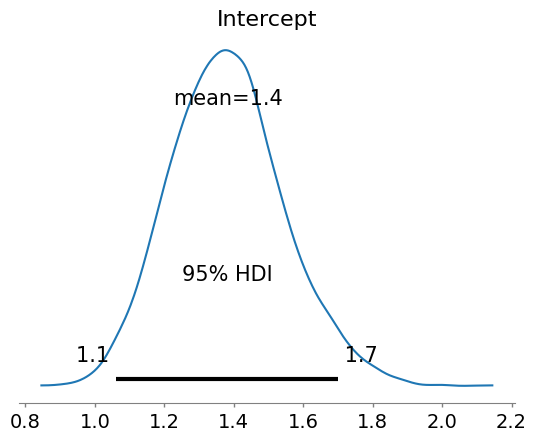

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.382,0.164,1.06,1.7,0.003,0.002,3506.0,5038.0,1.0


In [ ]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_2,var_names=['Intercept'],hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_2,var_names=['Intercept'],hdi_prob=0.95)

Como nota, es posible extraer los límites del intervalo de confianza con la función `hdi` de ArviZ ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.hdi.html)). Notarán que lo hice extrayendo los datos del Inference Data como matriz (ahora lo vemos bien como se hace). ¡Esto significa que la función sirve para cualquier vector de datos simulados!

In [ ]:
IC05,IC95 = az.hdi(np.ravel(results_2.posterior['Intercept'].values), hdi_prob=0.90)
print('Intervalo de confianza del 5%:',IC05)
print('Intervalo de confianza del 95%:',IC95)

Intervalo de confianza del 5%: 1.1039919745288835
Intervalo de confianza del 95%: 1.6444428674543181


### Distribución posterior predictiva (nuevas simulaciones)

Si quiero obtener nuevas simulaciones de cosas que no observé (años futuros en este caso), puedo hacerlo con el método `predict` ([LINK](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)). `kind='response'` indica que quiero simular no solo los parámetros del modelo sino también nuevos datos (si quisiera simular sólo los parámetros del modelo se haría con `kind='response_params'`, que es el default). Con `inplace=True` indico que quiero sobreescribir el Inference Data agregando las nuevas simulaciones, sin tener que guardarlo en una nueva variable.

Luego, la función `plot_ppc` que vimos antes permite gráficar las réplicas de mi ensayo, la posterior predictiva y comparar contra el histograma de los datos. Ya pueden empezar a ver qué tan probable es que su modelo genere algo parecido a sus datos.

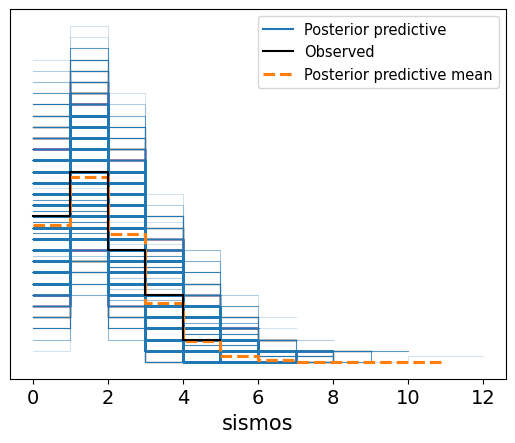

In [ ]:
# Nuevas simulaciones (lo guarda en la misma variable results_2 de antes con inplace=True)
model_2.predict(results_2, kind="response",inplace=True)

# Grafico
az.plot_ppc(results_2)
plt.show()

### Accediendo a las simulaciones

Como dijimos antes, el resultado de la inferencia y la predicción es un Inference Data. Verán que luego de predecir se agregó una nueva sección de nombre `posterior_predictive`. Allí van a encontrar las simulaciones de los datos/mi variable de interés, en tamaño (#cadenas,#simulaciones,#obs). Es decir, genera muchas réplicas de mi ensayo con el tamaño original de mis datos.

In [ ]:
results_2

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Estsa simulaciones pueden extraerse como Numpy Arrays para su manipulación o calculos (valores medios, cuantiles, cálculos de probabilidad, etc.

Abajo les dejamos como hacerlo para la posterior...

In [ ]:
results_2.posterior['Intercept'].values

array([[1.34113985, 1.2714891 , 1.3795142 , ..., 1.33372842, 1.45222458,
        1.45222458],
       [1.25996195, 1.25996195, 1.25996195, ..., 1.27119198, 1.37251958,
        1.37251958],
       [1.25819313, 1.46046933, 1.53772384, ..., 1.19583583, 1.36283996,
        1.52066309],
       [1.47989157, 1.42785102, 1.30121473, ..., 1.14817265, 1.29544642,
        1.3673799 ]])

Para la posterior predictiva...

In [ ]:
results_2.posterior_predictive['sismos'].values

array([[[1, 0, 1, ..., 1, 2, 0],
        [2, 4, 0, ..., 1, 0, 3],
        [1, 2, 1, ..., 1, 2, 0],
        ...,
        [0, 4, 1, ..., 1, 2, 2],
        [0, 0, 0, ..., 2, 3, 1],
        [2, 0, 2, ..., 1, 2, 4]],

       [[1, 3, 4, ..., 1, 3, 2],
        [4, 2, 3, ..., 3, 2, 2],
        [1, 2, 2, ..., 3, 0, 5],
        ...,
        [0, 3, 0, ..., 1, 0, 1],
        [0, 2, 0, ..., 3, 3, 1],
        [4, 2, 2, ..., 1, 1, 0]],

       [[1, 5, 0, ..., 1, 2, 0],
        [0, 2, 2, ..., 2, 1, 1],
        [1, 0, 1, ..., 2, 1, 2],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [2, 2, 1, ..., 2, 3, 0],
        [0, 1, 0, ..., 0, 1, 2]],

       [[1, 1, 3, ..., 0, 2, 1],
        [0, 0, 3, ..., 0, 2, 3],
        [2, 2, 1, ..., 2, 3, 1],
        ...,
        [0, 1, 1, ..., 0, 3, 0],
        [0, 2, 0, ..., 1, 1, 0],
        [1, 3, 3, ..., 0, 0, 2]]])

Y para los datos observados que se usaron.

In [ ]:
results_2.observed_data['sismos'].values

array([4, 1, 0, 1, 1, 1, 0, 0, 0, 3, 0, 2, 2, 0, 3, 2, 2, 3, 1, 2, 1, 0,
       1, 2, 3, 1, 0, 0, 3, 1, 1, 1, 1, 1, 1, 2, 4, 0, 2, 1, 2, 0, 1, 0,
       2, 1, 0, 3])

### Uso del modelo (contestar preguntas)

Todo esto lo hicimos con una razón: contestar nuestra pregunta original.

- ¿Cuál es la probabilidad de que no haya un sismo de moderada magnitud en los próximos 5 años?

Extrayendo los datos como vimos antes, ¡ahora simplemente es un problema de conteo como en el colab anterior de soluciones analíticas!

In [ ]:
# Accedo a los datos
Simul = results_2.posterior_predictive['sismos'].values

# Probabilidad de 0 sismos en 1 año
P0 = np.mean(np.ravel(Simul)==0)
print('Probabilidad de 0 sismos en 1 año:',round(P0,3))

# Probabilidad de 0 sismos en 5 años
P5 = P0**5
print('Probabilidad de 0 sismo en 5 año:',round(P5,5))

Probabilidad de 0 sismos en 1 año: 0.254
Probabilidad de 0 sismo en 5 año: 0.00106


## Ejemplo 3: Tiempo entre sismos en San Juan

Retomemos el dataset pero plantiémoslo "al revés" por así decir. En vez de ajustar la cantidad de sismos en un intervalo de tiempo, hagamos un modelo para el intervalo de tiempo entre sismos. La pregunta que queremos contestar es:

- ¿Cuál es la probabilidad de estar al menos 2 años sin un sismo de moderada magnitud?

### Datos

Los datos son los mismo de antes, solo que los vamos agrupar de otra manera.

In [ ]:
df_sismosFinal.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Main
4,2021-11-03 03:17:48.635000+00:00,-32.6971,-70.0638,100.25,5.7,mww,NaN,18.0,0.415,0.77,...,Chile-Argentina border region,earthquake,4.6,1.3,0.041,58.0,reviewed,us,us,1.0
32,2021-03-08 12:48:07.330000+00:00,-32.2039,-69.9055,106.66,5.2,mww,NaN,40.0,0.780,0.96,...,"95 km NE of Los Andes, Chile",earthquake,4.3,3.7,0.060,27.0,reviewed,us,us,1.0
44,2021-01-19 02:46:22.380000+00:00,-31.8334,-68.7992,20.81,6.4,mww,NaN,22.0,0.303,0.95,...,"26 km SW of Pocito, Argentina",earthquake,2.9,3.6,0.055,32.0,reviewed,us,us,1.0
128,2019-05-20 11:18:33.131000+00:00,-31.4782,-70.0028,108.00,5.5,mww,NaN,28.0,0.867,1.10,...,"57 km WSW of Calingasta, Argentina",earthquake,5.8,1.8,0.068,21.0,reviewed,us,us,1.0
139,2018-12-31 10:49:41.250000+00:00,-31.7756,-69.2343,99.39,5.3,mww,NaN,30.0,0.522,1.17,...,"52 km SSE of Calingasta, Argentina",earthquake,6.4,3.8,0.050,39.0,reviewed,us,us,1.0


Primero, vamos a ordenar los datos en orden cronológico. Luego, vamos a generar una columna que indique el tiempo transcurrido entre sismos en días (con decimales, no en forma discreta).

Así, entonces, nos quedan 63 sismos y 62 intervalos de tiempo entre sismos en un nuevo dataframe.

In [ ]:
# Ordeno el Dataframe por Fecha
df_sorted = df_sismosFinal.sort_values(by=['time'])

# Calculo la diferencia entre sismos en días
df_sorted['time_diff'] = df_sorted['time'].diff()
df_sorted['time_diff'] = df_sorted['time_diff'].dt.total_seconds()/60/60/24
df_sorted.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Main,time_diff
4875,1974-01-11 05:18:02.400000+00:00,-31.758,-68.376,122.0,5.4,mb,NaN,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1.0,NaN
4874,1974-01-23 21:43:51.300000+00:00,-32.165,-69.771,115.0,5.2,mb,NaN,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1.0,12.684594
4866,1974-08-14 17:56:47+00:00,-32.743,-69.015,132.0,5.6,mb,NaN,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1.0,202.842311
4865,1974-08-24 18:58:22.700000+00:00,-31.381,-67.378,32.0,5.4,mb,NaN,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1.0,10.042774
4849,1975-11-17 06:45:47.200000+00:00,-31.548,-69.179,122.0,5.3,mb,NaN,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1.0,449.491256


Abajo pueden ver el histograma de los intervalos de tiempo. Parece una exponencial, ¿no?

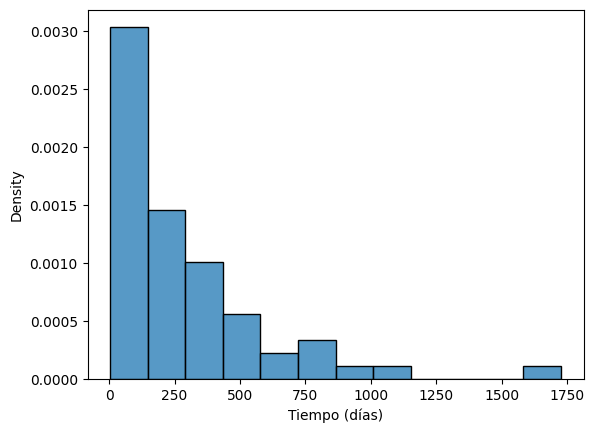

In [ ]:
sns.histplot(df_sorted['time_diff'],label='Tiempo entre sismos',stat='density')
plt.xlabel('Tiempo (días)')
plt.show()

Noten también que el valor medio y el desvío estándar son muy parecidos. Esto es una propiedad de la distribución exponencial

$$y\sim exp(\beta=1/\lambda)$$

$$\bar{y}=\beta$$

$$\sigma_{y} = \beta$$

Por lo que podría ser un buen modelo de generación de datos para este problema. Como comentario, si el conteo de eventos sigue una Poisson de parámetro $\lambda$, se puede demostrar que el intervalo de tiempo entre eventos sigue una Exponencial de parámetro $\beta=1/\lambda$.

In [ ]:
mu = df_sorted['time_diff'].mean()
s = df_sorted['time_diff'].std()

print('media',mu)
print('desvío',s)

media 281.659943666928
desvío 304.2713906496681


### Construcción del modelo exponencial

A continuación, pueden ver la carga del modelo exponencial, aclarando el link y la distribución a priori:

Modelo:

$$y \sim Exp(\beta)$$

Fórmula para el valor medio:

$$\beta = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim HN(\sigma)$$

Donde $HN$ es la distribución HalfNormal (la mitad de la campana de una distribución normal centrada en 0, lo que hace que el parámetro solo tome valores positivos). $\sigma$ se adoptó como 300, asumiendo que el parámetro no puede valer más de 600 (no más de 600 días como intervalo promedio entre sismos).

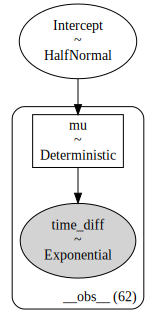

In [ ]:
# Construccion del Modelo Exponencial
# Prioris
prioris = {"Intercept": bmb.Prior("HalfNormal",sigma=300)}

# Modelo
model_A = bmb.Model('time_diff~1',data=df_sorted,dropna=True,family='exponential',
                    link='identity', priors=prioris)

model_A.build()
model_A.graph()

Abajo pueden ver la distribución a priori elegido (para que se familiaricen con la forma, es muy útil para datos positivos), y la priori-predictiva para verificar que hace lo que yo quería.

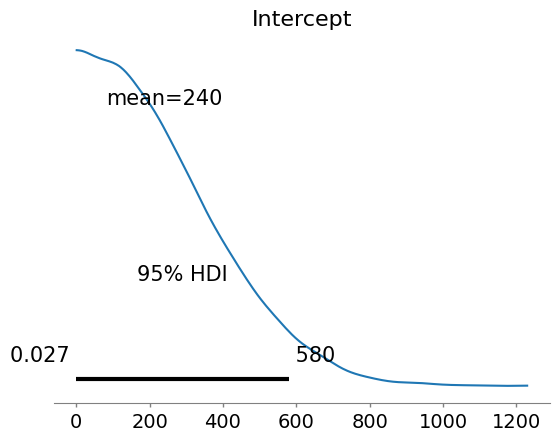

In [ ]:
model_A.plot_priors(hdi_prob=0.95)
plt.show()

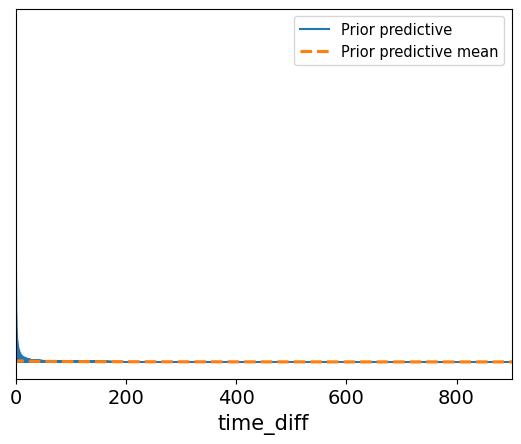

In [ ]:
# Simulaciones de la priori predictive
priorcheck_A = model_A.prior_predictive(draws=2000)

# Gráfico
az.plot_ppc(priorcheck_A,group='prior')
plt.xlim(-1,900)
plt.show()

Luego, podemos hacer la inferencia como vimos antes, y hacer el diagnóstico...

Output()

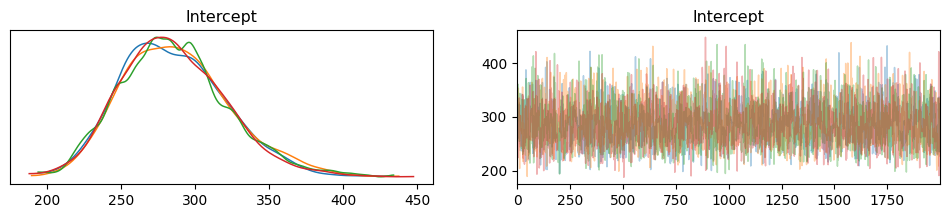

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,286.285,36.503,219.807,360.423,0.603,0.398,3638.0,5766.0,1.0


In [ ]:
# Hacer inferencia
results_A = model_A.fit(draws=2000,chains=4)

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_A, compact=False)
plt.show()

# Numerico
az.summary(results_A,hdi_prob=0.95)

Graficar las distribuciones posteriores de los parámetros...

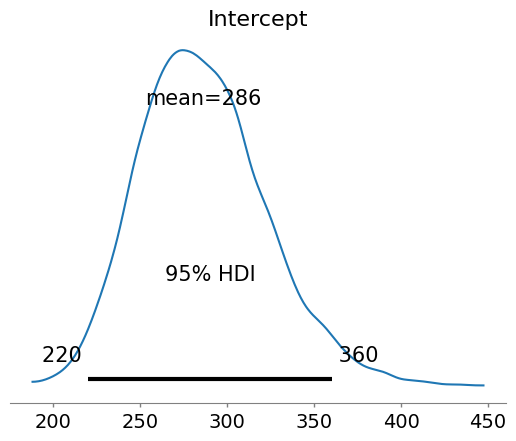

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,286.285,36.503,219.807,360.423,0.603,0.398,3638.0,5766.0,1.0


In [ ]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_A,hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_A,hdi_prob=0.95)

Y ¡generar nuevos datos y evaluar cuánto se parecen las simulaciones a los datos observados!

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


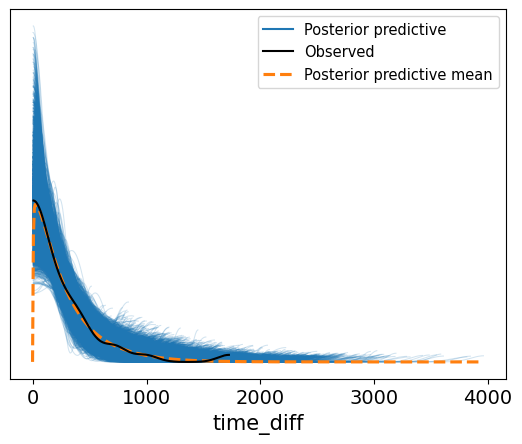

In [ ]:
# Nuevas simulaciones (lo guarda en la misma variable de antes con inplace=True)
model_A.predict(results_A, kind="response",inplace=True)

# Grafico
az.plot_ppc(results_A)
plt.show()

### Construcción del modelo LogNormal

Otro modelo que se suele usar para este tipo de problemas es el LogNormal (la distirbución Gamma y Weibull también son muy usadas).

Como la LogNormal es una familia muy utilizada y que tiene sus particularidades, es importante prestarle un poco de detalle.

Por un lado, la distribución LogNormal no está pre-cargada en `Bambi`. Si bien podríamos construirla nosotros de forma relativamente sencilla, en realidad lo más común es convertir el problema a uno Normal, ajustando el logaritmo de los datos.

Es decir, en vez de resolver

$$Y\sim LN(m,s)$$

vamos a usar el modelo

$$ln(Y) \sim N(m,s)$$

¡que es un típico modelo normal muy fácil de resolver! Para hacer esto no es necesario editar el dataframe con los datos, sino que simplemente puede hacerse a través de la fórmula, aclarando que se quiere ajustar el logaritmo de la columna en vez de la columna propiamente dicha

Entonces,

Modelo:

$$ln(y) \sim N(m,s)$$

Fórmula para el valor medio (del logaritmo):

$$m = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(\sigma)$$

Nota: La distribución LogNormal tiene dos parámetros, pero solo definimos la fórmula para el valor medio. Eso es porque el desvío es considerado un término de error en `bambi` (así es en todas las distribuciones multi-paramétricas). Más adelante veremos qué pasa si queremos editar esto. Por default, entonces, `Bambi` siempre considera:

$$s = sigma$$

$$p(sigma) \sim Half-t_{\nu}(\tau)$$

o la priori que eligamos/corresponda. En este ejemplo vamos a usar las prioris por default por simplicidad, ya que estamos usando el link por default y confiamos que adoptará algo poco-informativo.

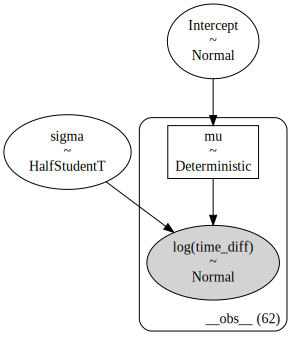

In [ ]:
# Construccion del Modelo Exponencial

# Modelo
model_B = bmb.Model('log(time_diff)~1',data=df_sorted,dropna=True)

model_B.build()
model_B.graph()

Abajo pueden ver las ditribuciones a priori para `Intercept` y `sigma`.

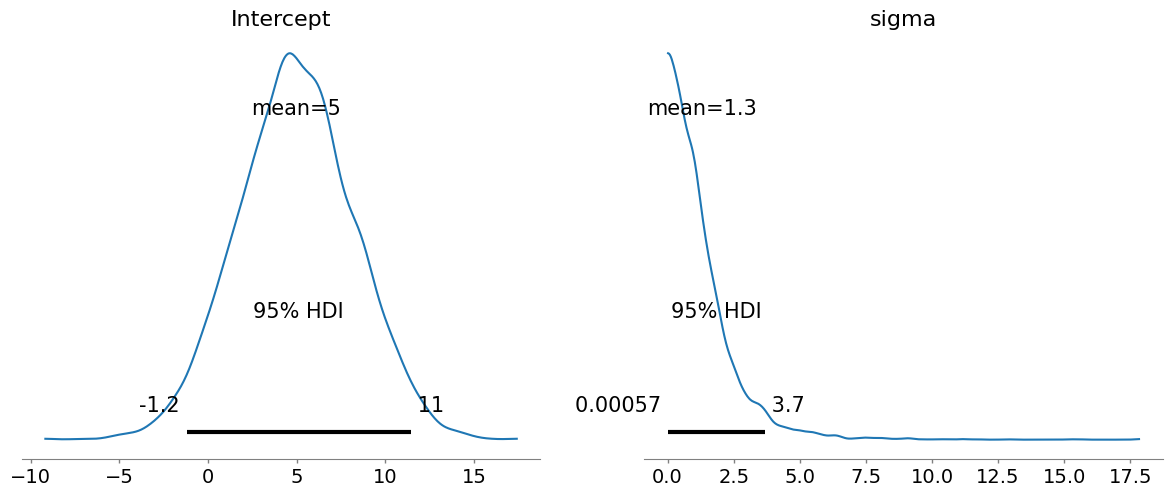

In [ ]:
model_B.plot_priors(hdi_prob=0.95)
plt.show()

Y la priori predictiva. Van a notar algo "raro". ¡El modelo lo que devuelve es simulaciones del logaritmo de lo que yo quiero debido a la transformación!

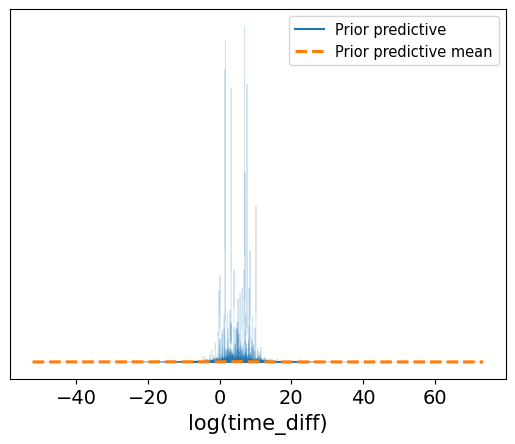

In [ ]:
# Simulaciones de la priori predictive
priorcheck_B = model_B.prior_predictive(draws=2000)

# Gráfico
az.plot_ppc(priorcheck_B,group='prior')
#plt.xlim(-1,900)
plt.show()

In [ ]:
priorcheck_B

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

#### Aplicacion de transformacion a las simulaciones

Es necesario entonces, transformar los datos (y cambiarles el nombre para dejarlo de manifiesto). Esto puede hacerse con los métodos `map` ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.map.html#arviz.InferenceData.map)) y `rename` ([LINK](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.rename.html)) de ArviZ.

Abajo les dejamos como hacerlo. Lo recomendable es generar un nuevo Inference Data (con `inplace=False` y guardándolo en una nueva variable). Noten que esto sirve para cualquier tipo de transformación.

In [ ]:
# Transformar resultados de Y a escala deseada
priorcheck_B_T = priorcheck_B.map(lambda x: np.exp(x), groups="observed_vars",
                                  inplace=False)

# Renombrar variable de log(time_diff) a time_diff luego de aplicar transformacion
priorcheck_B_T.rename(name_dict={'log(time_diff)':'time_diff'}, inplace=True)

priorcheck_B_T

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Y ahora sí el chequeo de la priori predictiva está en mi escala original y es comparable con el modelo exponencial.

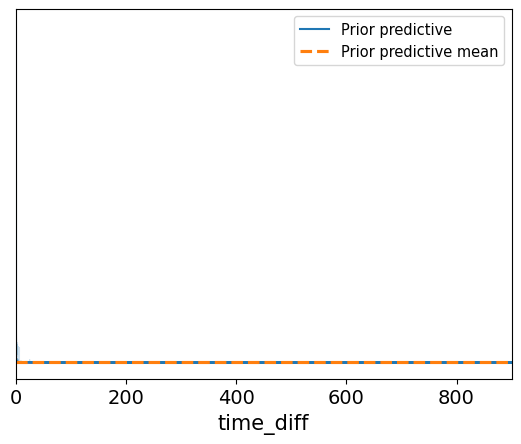

In [ ]:
# Gráfico
az.plot_ppc(priorcheck_B_T,group='prior')
plt.xlim(-1,900)
plt.show()

¡Una vez que contruí el modelo es todo lo mismo de antes!

La inferencia y diagnóstico...

Output()

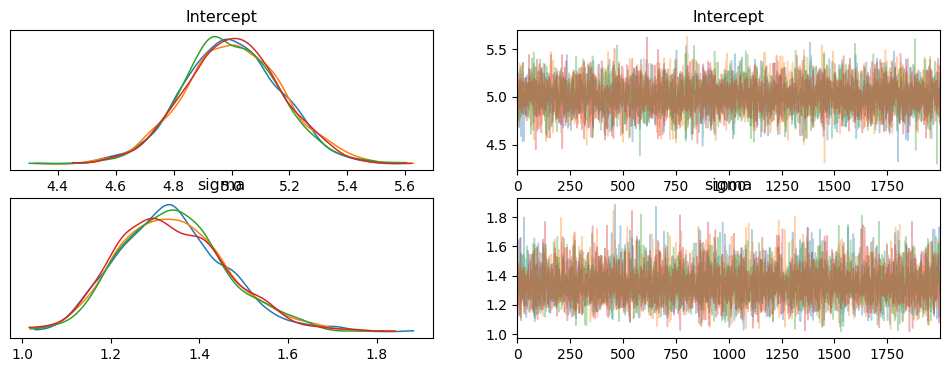

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,5.003,0.167,4.686,5.338,0.002,0.002,7592.0,5566.0,1.0
sigma,1.341,0.123,1.115,1.585,0.001,0.001,7487.0,4909.0,1.0


In [ ]:
# Hacer inferencia
results_B = model_B.fit(draws=2000,chains=4)

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_B, compact=False)
plt.show()

# Numerico
az.summary(results_B,hdi_prob=0.95)

Las distribuciones posteriores de los parámetros...

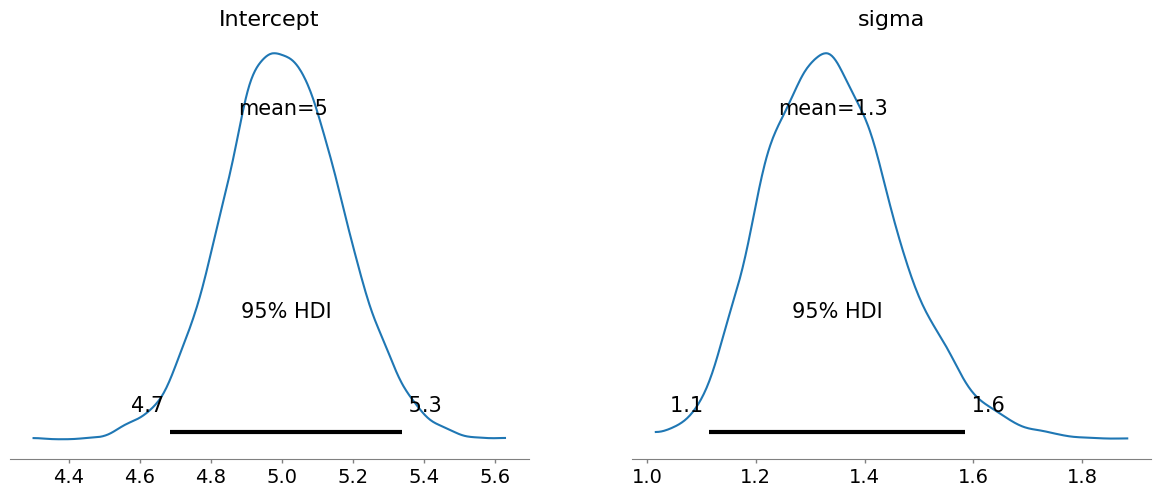

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,5.003,0.167,4.686,5.338,0.002,0.002,7592.0,5566.0,1.0
sigma,1.341,0.123,1.115,1.585,0.001,0.001,7487.0,4909.0,1.0


In [ ]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_B,hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_B,hdi_prob=0.95)

Y la simulación de nuevos datos. En este último caso, ¡haciendo la misma transformación de antes para volver a la escala original!

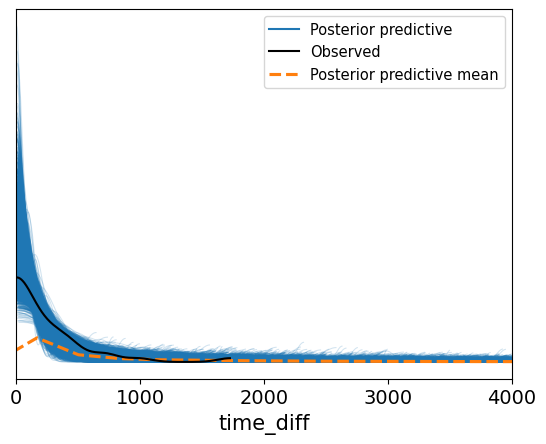

In [ ]:
# Nuevas simulaciones (lo guarda en la misma variable de antes con inplace=True)
model_B.predict(results_B, kind="response",inplace=True)

# Transformar resultados de Y a escala deseada
results_B_T = results_B.map(lambda x: np.exp(x), groups="observed_vars",
                                  inplace=False)

# Renombrar variable de log(time_diff) a time_diff luego de aplicar transformacion
results_B_T.rename(name_dict={'log(time_diff)':'time_diff'}, inplace=True)


# Grafico
az.plot_ppc(results_B_T)
plt.xlim(-1,4000)
plt.show()

No parece ajustar tan bien como la exponencial, ¿no?

### Uso del Modelo

Supongamos que de los modelos que armamos antes, nos "gustó" más el exponencial. ¡Ahora ya podemos usarlo para contestar preguntas!

La pregunta era: ¿Cuál es la probabilidad de que el intervalo entre sismos supere los 2 años?

Extrayendo las simulaciones del Inference Data, esto lo podemos contestar por conteo igual que antes.

In [ ]:
# Accedo a los datos
Simul = results_A.posterior_predictive['time_diff'].values

# Probabilidad de superar un intervalo de 2 años
P0 = np.mean(np.ravel(Simul)>2*365)
print('Probabilidad de que el intervalo entre sismos supere 2 años:',round(P0,3))

Probabilidad de que el intervalo entre sismos supere 2 años: 0.079
